In [368]:
import numpy as np
import healpy as hp
from astropy.io import fits
from scipy.optimize import least_squares
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors

'''rcParams['mathtext.rm'] = 'Computer Modern'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'

font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})'''

#My own files 
from MyUnits import *
from file_dict import file_dict

HomeDir = './'
DataDir = HomeDir + 'template_data/'

# Useful Functions

In [369]:
# Get rid of slice |b| < b_min degrees
def remove_b(skymap, b_min):
    nside = hp.npix2nside(len(skymap))
    skymap_cp = np.copy(skymap)
    lon, lat = hp.pix2ang(nside, np.arange(len(skymap_cp)), nest = False, lonlat = True)
    skymap_cp[np.abs(lat)<b_min] = np.nan
    
    return skymap_cp

#Brightness temperature of CMB
def cmb_bt(freq):
    return (2.72548 * Kelvin) *(2 * np.pi * freq/(2.72548 * Kelvin)) /(np.exp(2 * np.pi * freq/(2.72548 * Kelvin))-1)

#Fornengo's colormap
fng_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["black", "blue", "yellow","red"])

# Get Template Maps

## Data and Synchrotron maps

In [370]:
freq =  # Frequency of interest, in MHz
data_dict = file_dict.get(str(freq))

radio_temps = np.load(data_dict.get('skymap')) # Temperature data
print(len(radio_temps[np.isnan(radio_temps)]))
radio_temps[radio_temps < 0] = np.nan

galprop_temps = np.load(data_dict.get('synch_map')) # GALPROP Synchrotron simulation

# RMS and Calibration Error
RMS = data_dict.get('rms')
CALIB = data_dict.get('calib')

2840


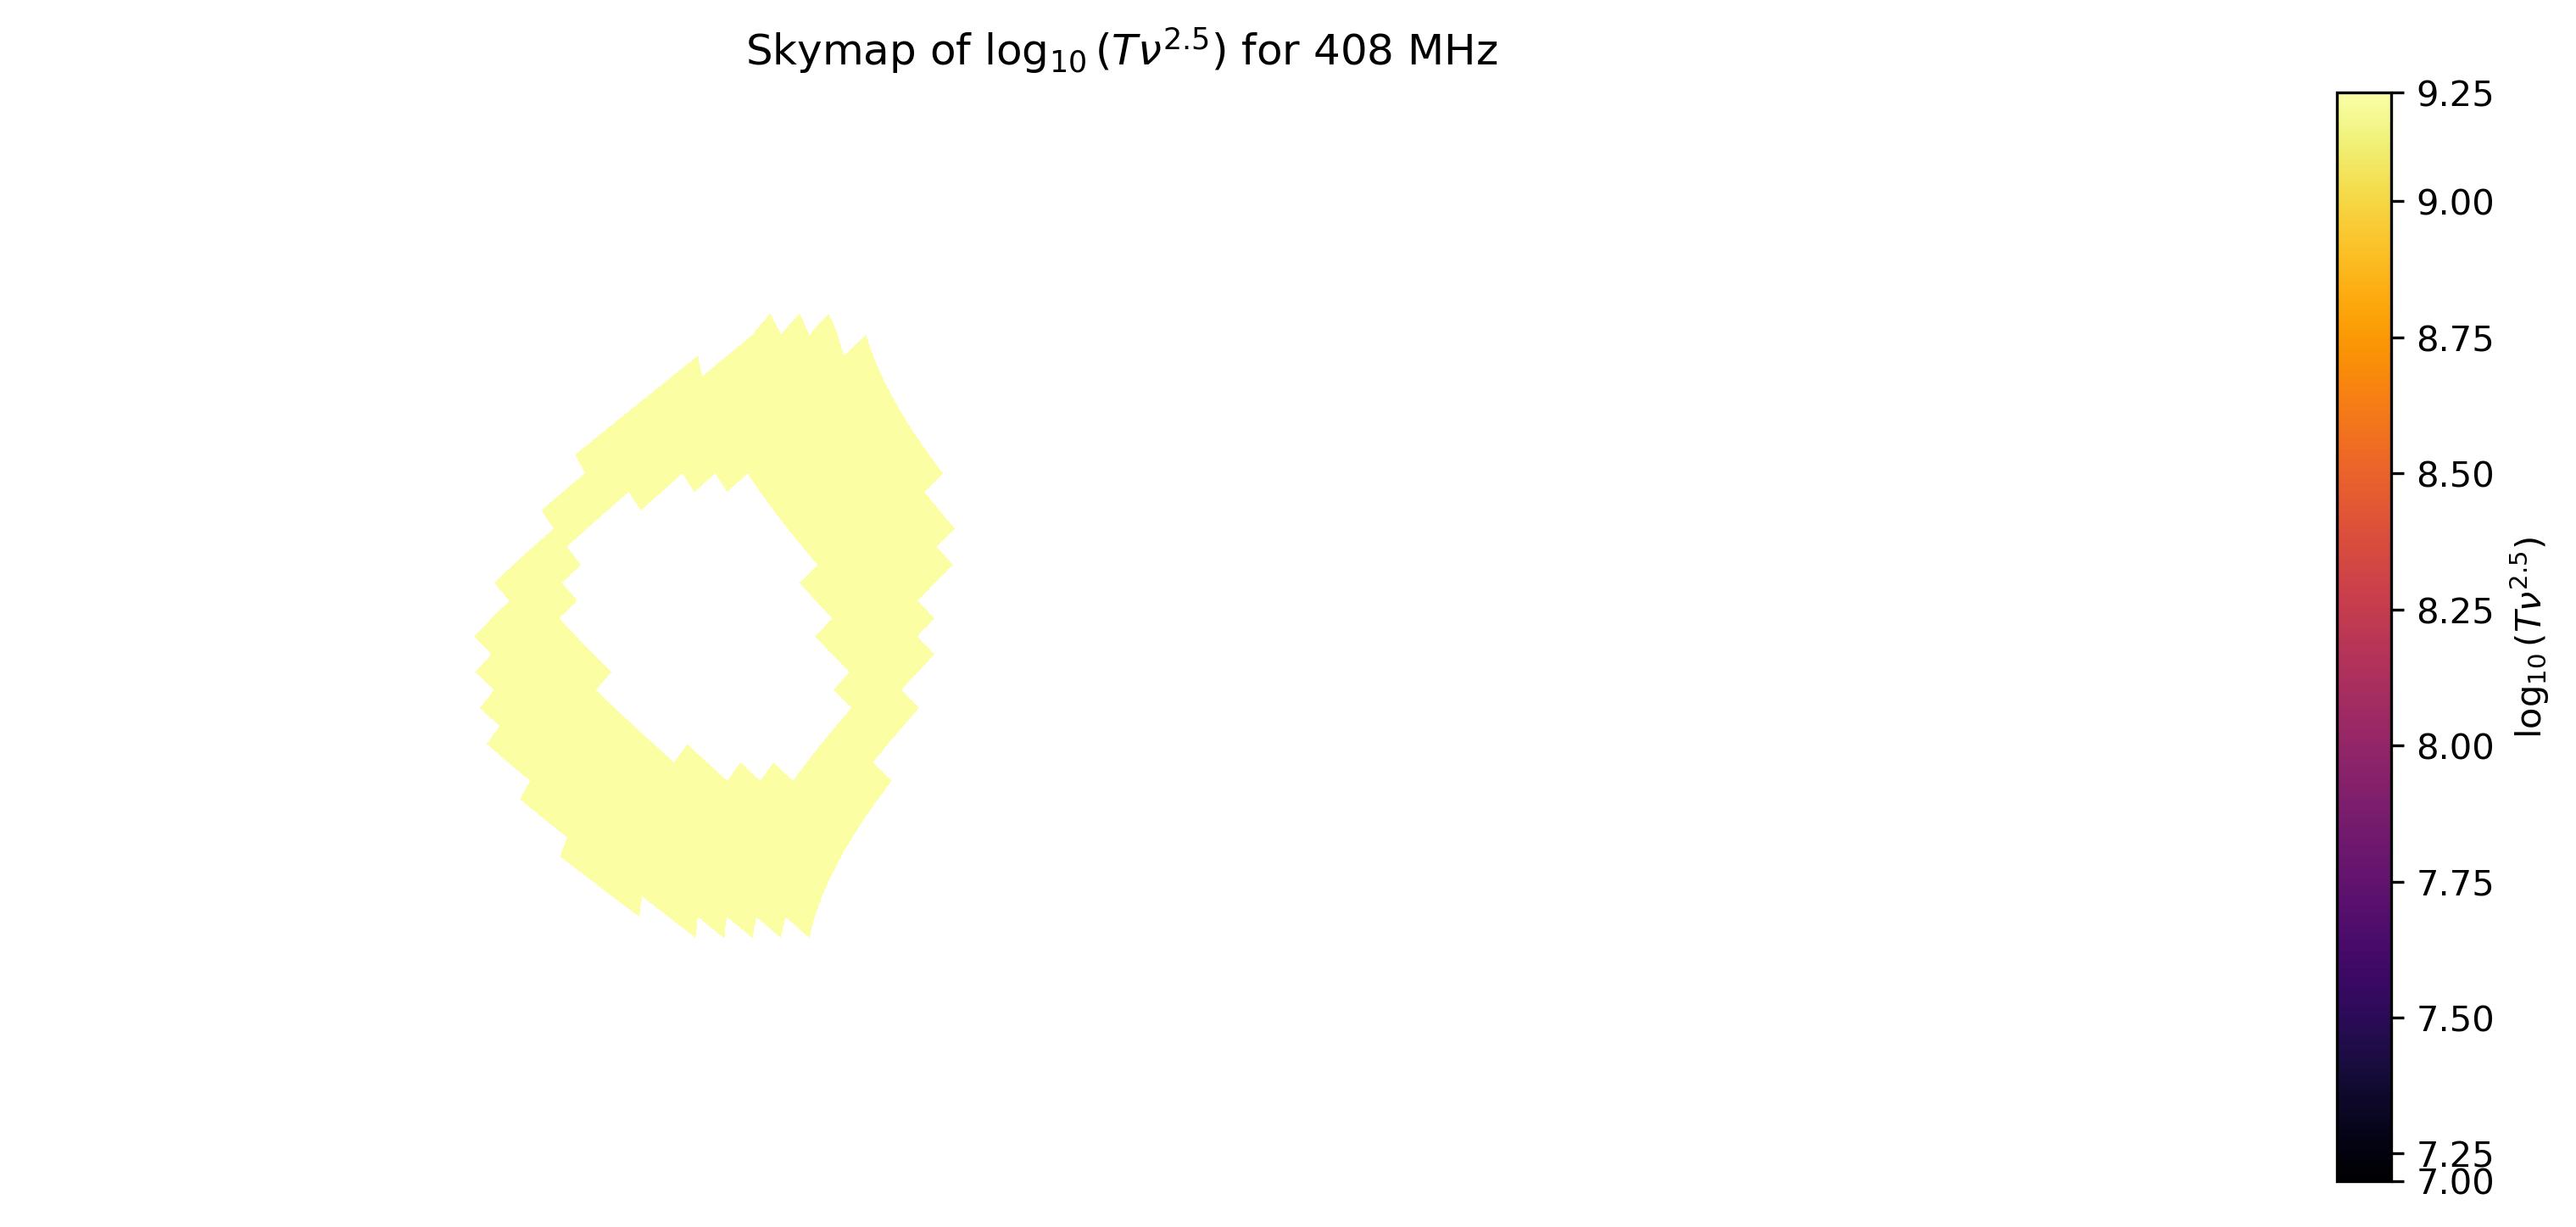

In [371]:
plt.subplots(1,1,figsize=(12,6),dpi = 300)
map = np.log10((radio_temps) * (freq ** 2.5))
hp.mollview(map, xsize = 4000, nest = False, hold = True, min = 7.2, max = 9.2, cmap = 'inferno', title=r"Skymap of $\log_{10}(T \nu ^{2.5})$ for 408 MHz", badcolor = 'white', cbar = None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T \nu^{2.5})$')

In [372]:
len(radio_temps)

3072

In [373]:
# Point source

In [374]:
pt_src = np.load(DataDir + 'pt_src.npy')

/tmp/ipykernel_1374908/101340865.py:2: RuntimeWarning: invalid value encountered in log10
  map = np.log10(pt_src* (408 ** 2.5) + 1e-10)


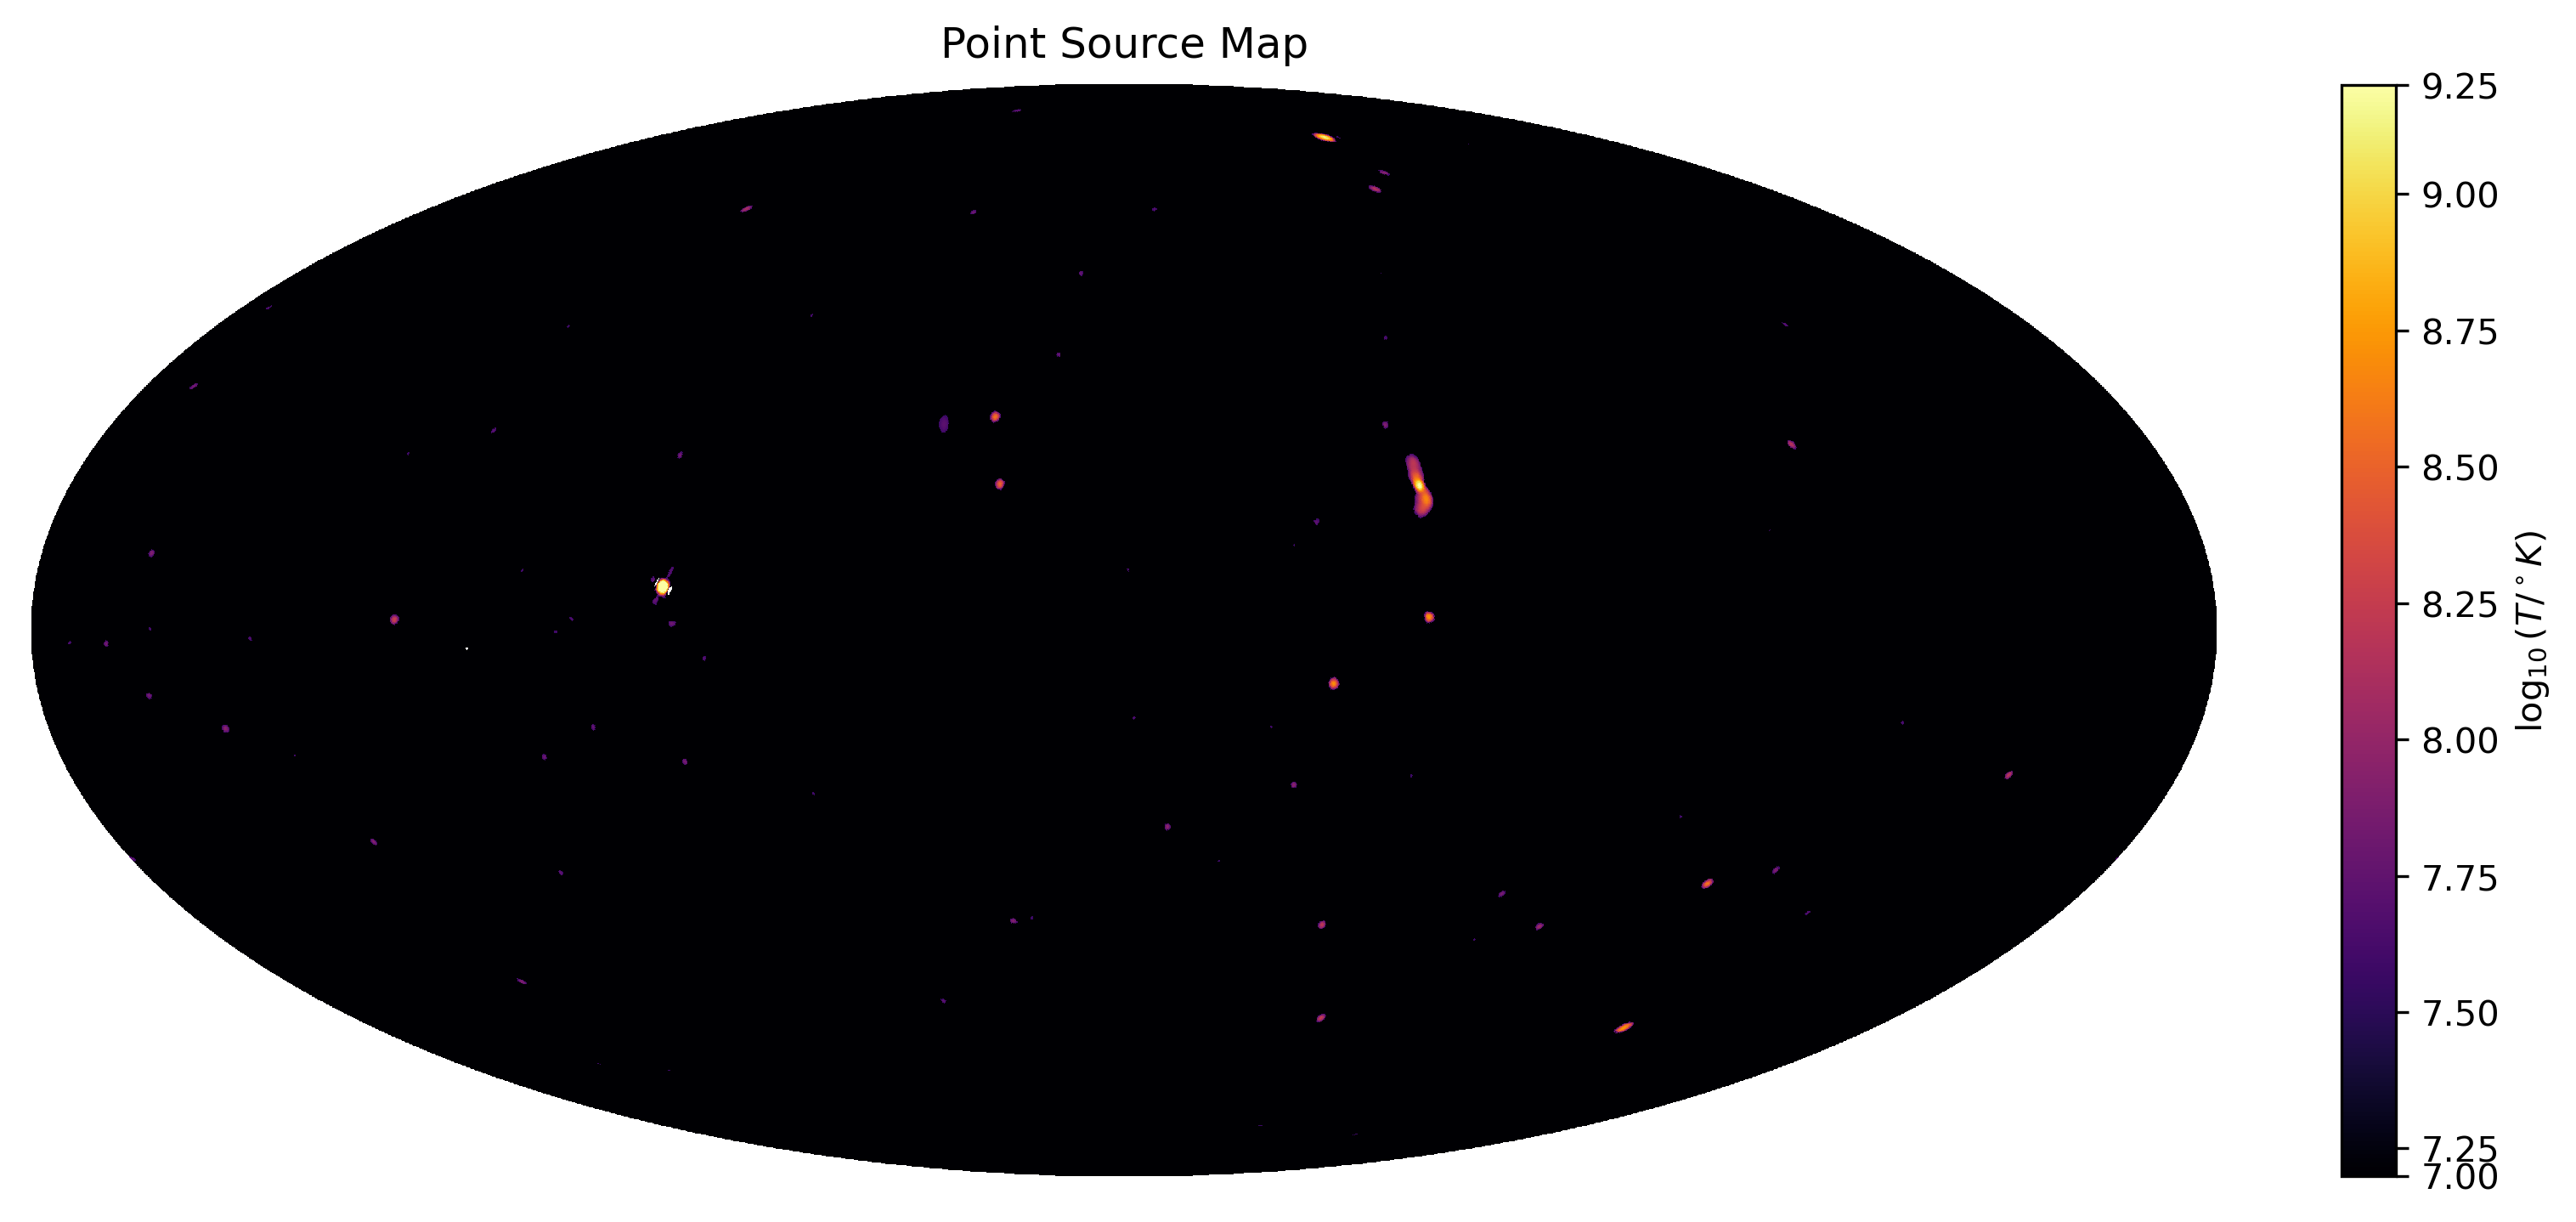

In [375]:
plt.subplots(1,1,figsize=(12,6),dpi = 300)
map = np.log10(pt_src* (408 ** 2.5) + 1e-10)
hp.mollview(map, xsize = 4000, nest = False, cmap = 'inferno', min = 7.2, max = 9.2, hold = True, cbar = False, title=r'Point Source Map', badcolor = 'white')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

## Remove overlap with point source template

In [376]:
source_templ = np.load(DataDir + 'src_map.npy')

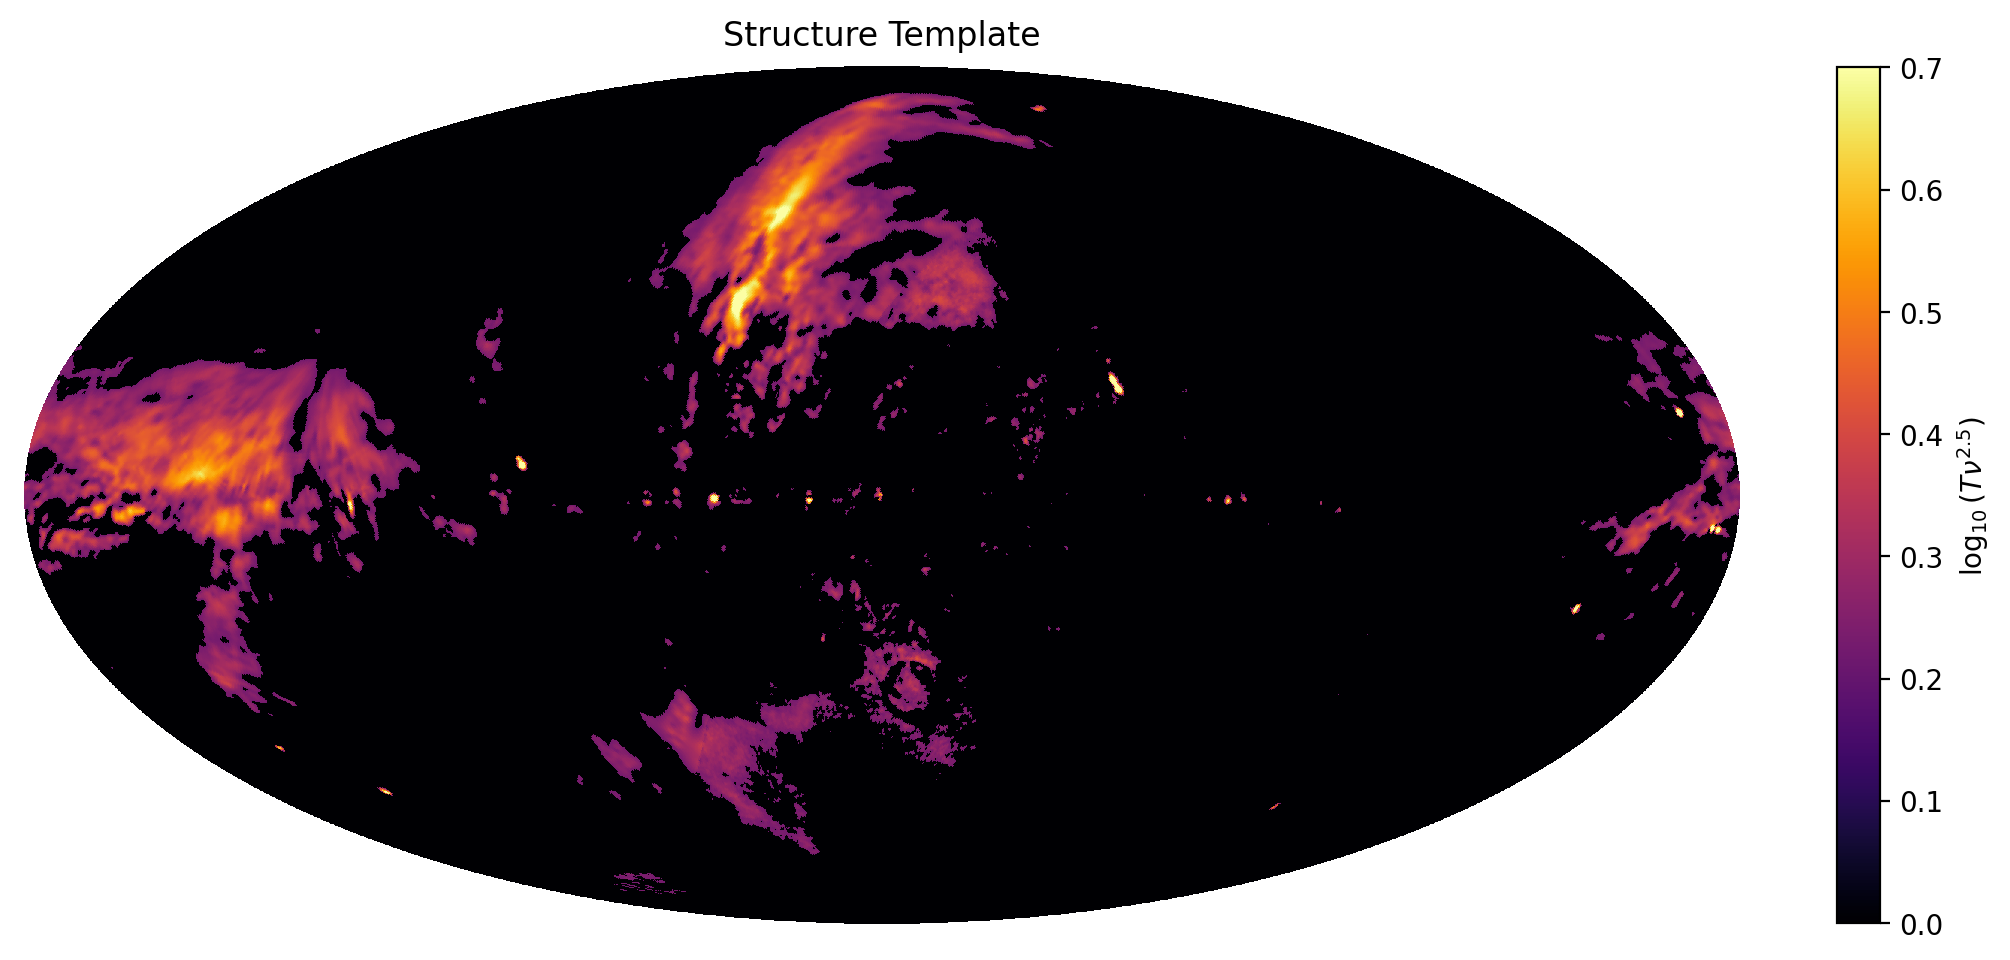

In [377]:
plt.subplots(1,1,figsize=(12,6),dpi = 200)
map = source_templ
hp.mollview(map, xsize = 4000, nest = False, hold = True, min = 0, max = 0.7, cmap = 'inferno', title=r"Structure Template", badcolor = 'white', cbar = None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T \nu^{2.5})$')

In [378]:
pt_src_dgd = hp.ud_grade(pt_src, hp.npix2nside(len(source_templ)))

In [379]:
source_templ[pt_src_dgd > 0] = 0

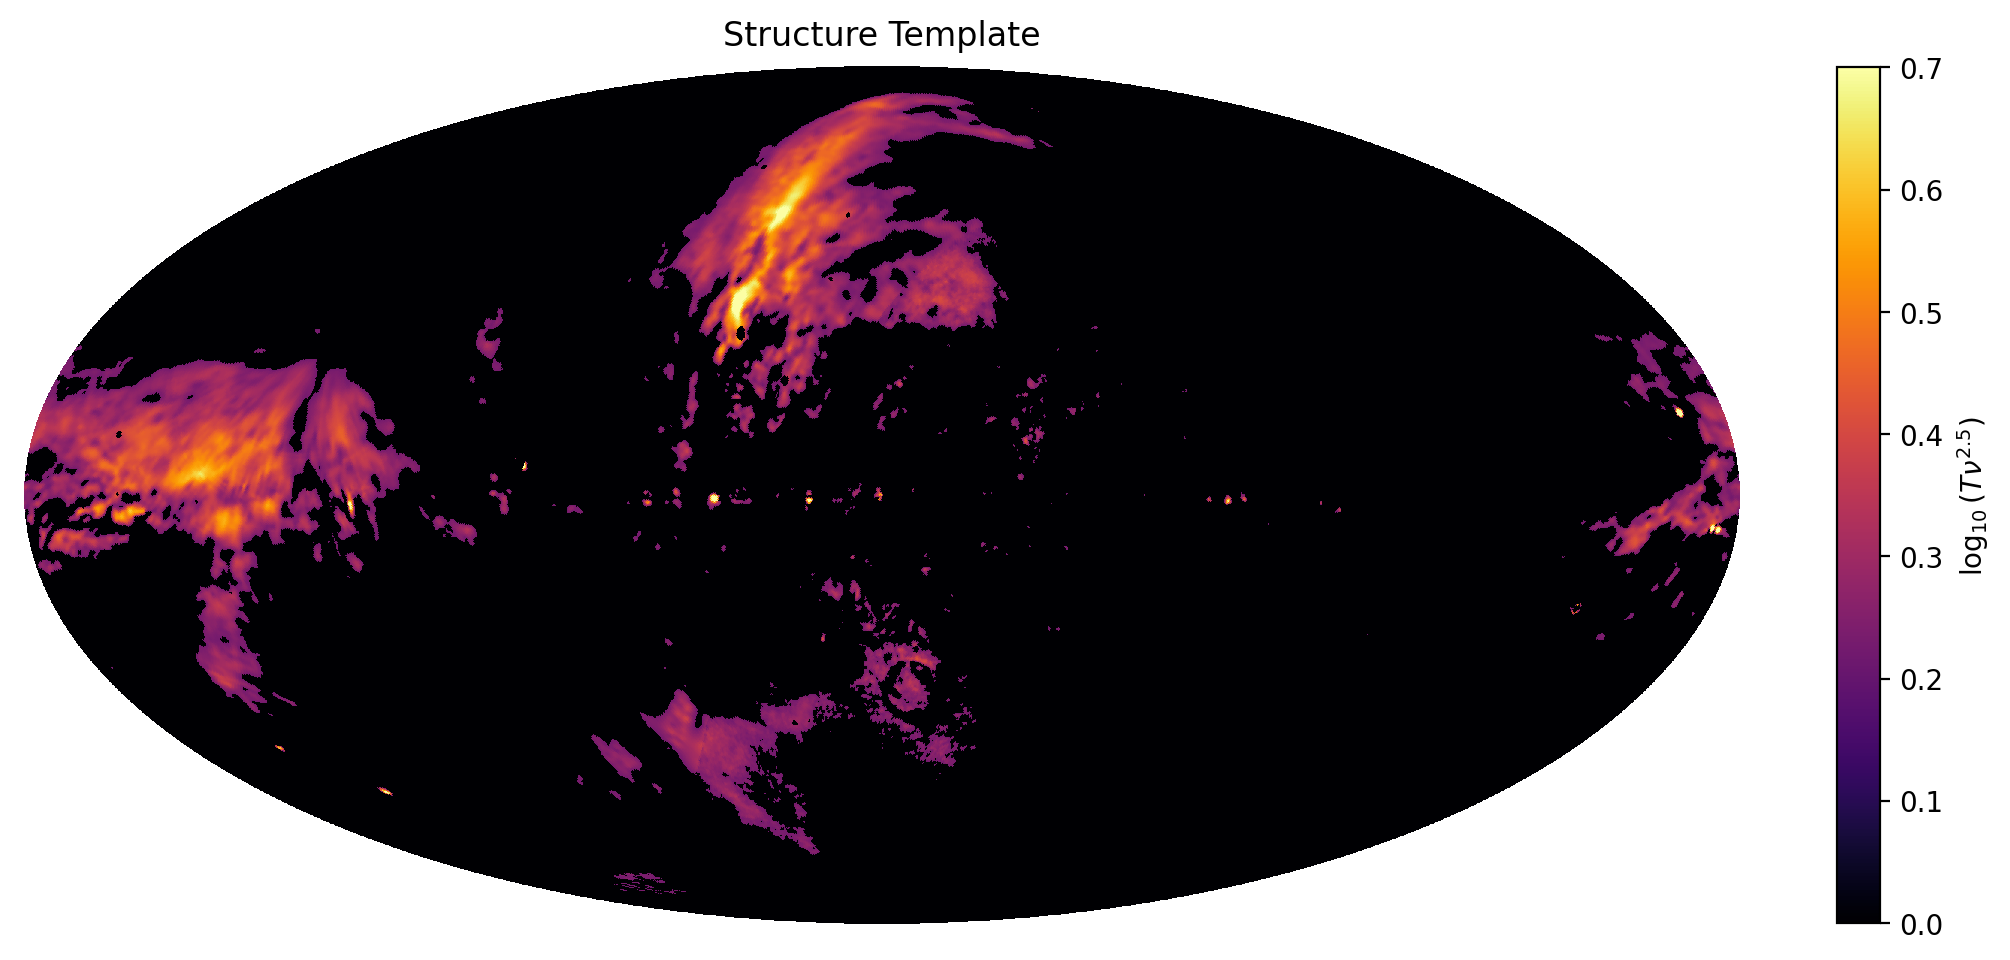

In [380]:
plt.subplots(1,1,figsize=(12,6),dpi = 200)
map = source_templ
hp.mollview(map, xsize = 4000, nest = False, hold = True, min = 0, max = 0.7, cmap = 'inferno', title=r"Structure Template", badcolor = 'white', cbar = None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T \nu^{2.5})$')

In [381]:
#np.save(DataDir + 'struct_map.npy', source_templ)

## Synchrotron Template

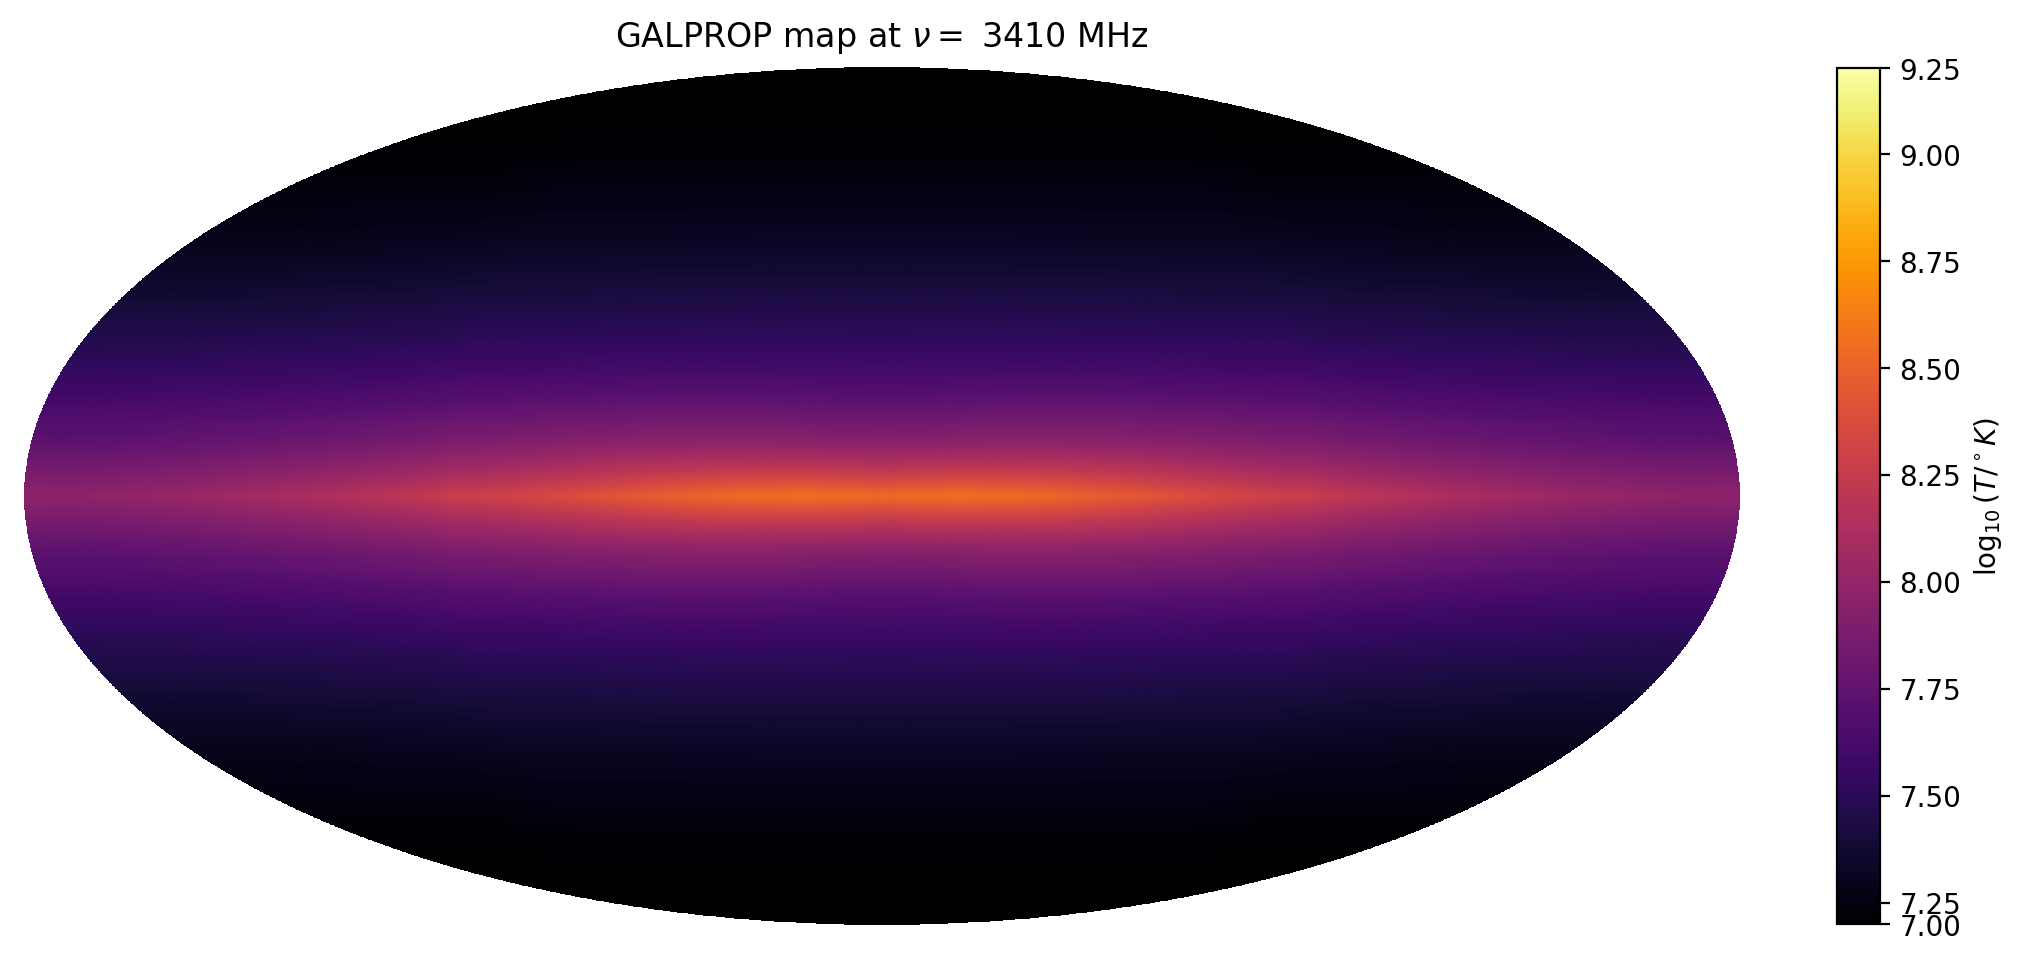

In [382]:
plt.subplots(1,1,figsize=(12,6),dpi = 200)
map = np.log10(galprop_temps* (freq ** 2.5))
hp.mollview(map, xsize = 4000, nest = False, cmap = 'inferno', min = 7.2, max = 9.2, hold = True, cbar = False, title=r'GALPROP map at $\nu=$ ' + str(freq) + ' MHz', badcolor = 'white')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

## Bremsstrahlung Map

In [383]:
halpha_temps = np.load(DataDir + 'ff_map.npy')

In [384]:
#halpha_temps = hp.pixelfunc.reorder(halpha_temps, n2r = True)

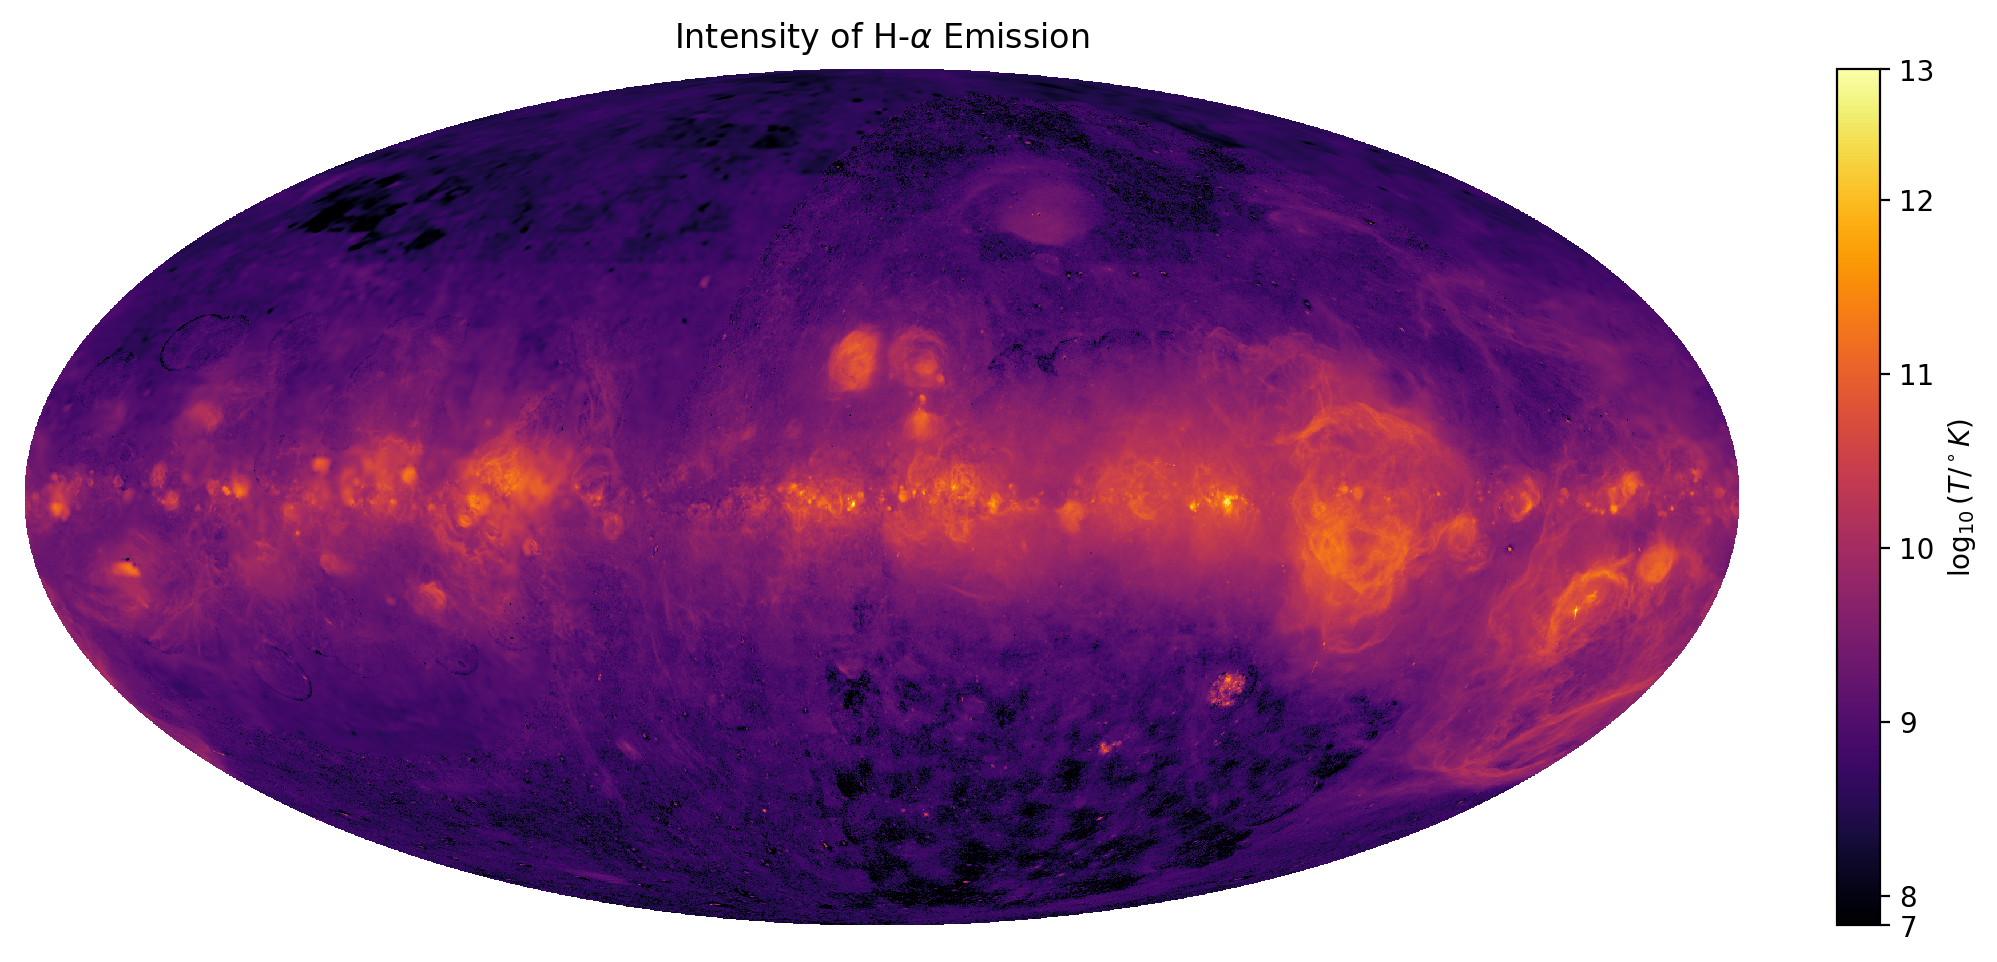

In [385]:
plt.subplots(1,1,figsize=(12,6),dpi = 200)
map = np.log10(halpha_temps * (freq ** 2.5))
hp.mollview(map, xsize = 3000, nest = False, cmap = 'inferno', hold = True, cbar = False, title=r'Intensity of H-$\alpha$ Emission', badcolor = 'white')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [386]:
#np.save(DataDir + 'ff_map.npy', halpha_temps)

# Fluctuation map (parallelized)

- Most of diffuse Galactic synchrotron emission is induced by the random component of the GMF
- Random magnetic field introduces a variance in the intensity of radio maps
- Must average out fluctuations due to random magnetic field and compare data with that
- Can directly infer these fluctuations by looking at intensity variance in a given angular region, estimate how well synch model reproduces observations

In [387]:
'''radio_temps_c = hp.pixelfunc.ud_grade(radio_temps, 128, pess=True)
radio_temps_c[radio_temps_c < 0] = np.nan'''

skymap = radio_temps - cmb_bt(freq * MHz)/Kelvin

In [388]:
nside = hp.npix2nside(len(skymap))
pix_list = np.arange(len(skymap))
vectors = hp.pix2vec(nside, pix_list)
resol = min(hp.npix2nside(len(skymap)), 64); print(resol)

RADIUS = hp.pixelfunc.max_pixrad(resol, degrees = True) / 2

#parallel routine

def fluct_map_par(idx, skymap, nside, vec, rms, calib):
    if (np.isnan(skymap[idx])):
        return np.nan
    else:
        inds = hp.query_disc(nside, (vec[0][idx], vec[1][idx], vec[2][idx]), radius = RADIUS * degree, inclusive = True)
        temps = skymap[inds]
        temps_r = temps[~np.isnan(temps)]
        
        f = np.sqrt(np.var(temps_r) + rms**2 + (calib * skymap[idx])**2)
        return f

16


In [389]:
num_cores_used = 40

f_map = Parallel(n_jobs=num_cores_used)(delayed(fluct_map_par)(idx, skymap, nside, vectors, RMS, CALIB)
                                              for idx in pix_list)

In [390]:
f_map_np = np.asarray(f_map)

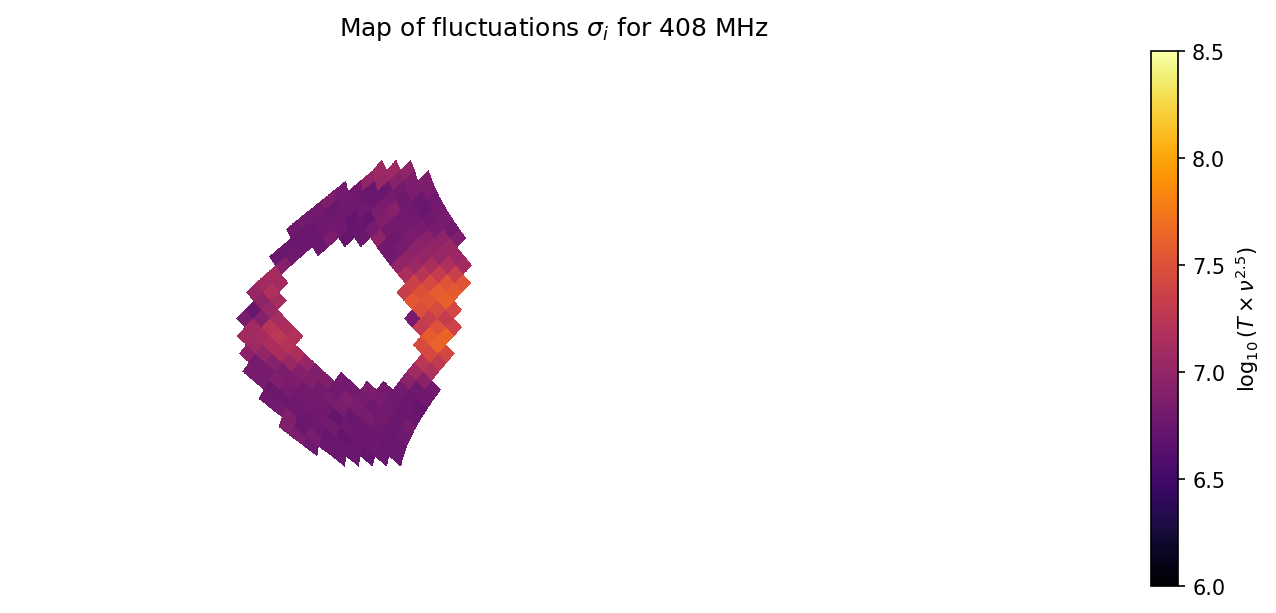

In [391]:
plt.subplots(1,1,figsize=(10,5),dpi = 150)
map = np.log10(f_map_np * (freq**2.5))
hp.mollview(map, xsize = 4000, nest = False, hold = True, cmap = 'inferno', min = 6, max = 8.5, title=r"Map of fluctuations $\sigma_i$ for 408 MHz", badcolor = 'white', cbar = None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T\times \nu^{2.5})$')

# Making the fit

In [392]:
# raw data
data_map = radio_temps - cmb_bt(freq * MHz) / Kelvin

#synchrotron map: GALPROP
synch_map = galprop_temps

#free-free map: Finkbeiner
free_free = halpha_temps

#error_map
error_map_sq = f_map_np**2

#structure templates
struct_map = source_templ

#point sources
pt_src_map = pt_src

In [393]:
# downgrade to desired resolution
data_map_dg = hp.ud_grade(data_map, resol, pess = True)

synch_map_dg = hp.ud_grade(synch_map, resol, pess = True)
free_free_dg = hp.ud_grade(free_free, resol, pess = True)
struct_map_dg = hp.ud_grade(struct_map, resol, pess = True)
pt_src_map_dg = hp.ud_grade(pt_src_map, resol, pess = True)
error_map_sq_dg = hp.ud_grade(error_map_sq, resol, pess = True)#, power = 2)

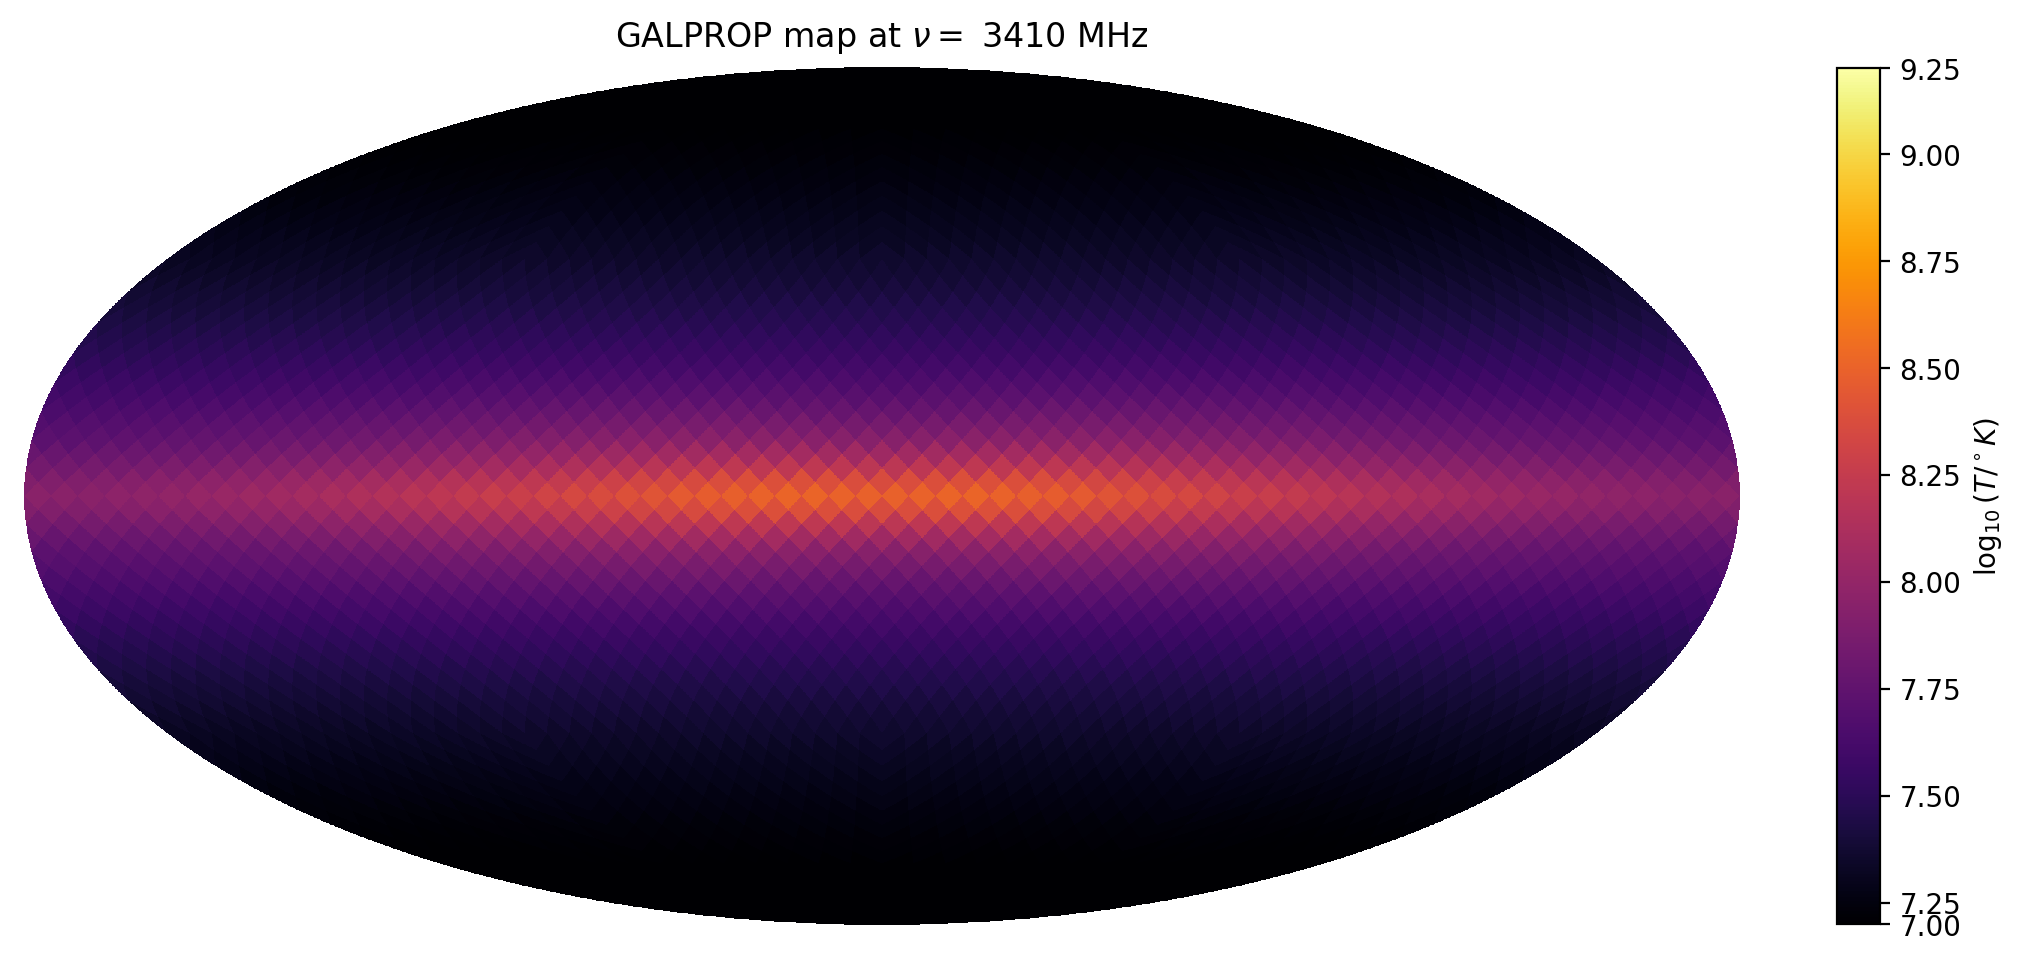

In [394]:
plt.subplots(1,1,figsize=(12,6),dpi = 200)
map = np.log10(synch_map_dg* (freq ** 2.5))
hp.mollview(map, xsize = 4000, nest = False, cmap = 'inferno', min = 7.2, max = 9.2, hold = True, cbar = False, title=r'GALPROP map at $\nu=$ ' + str(freq) + ' MHz', badcolor = 'white')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T/^\circ K)$')

In [395]:
# Taking care of NANs
synch_map_dg[data_map_dg < 0] = np.nan
free_free_dg[data_map_dg < 0] = np.nan
struct_map_dg[data_map_dg < 0] = np.nan
error_map_sq_dg[data_map_dg < 0] = np.nan
pt_src_map_dg[data_map_dg < 0] = np.nan

data_map_dg[data_map_dg < 0] = np.nan

In [396]:
# Mask out low-b region
nside = resol
b_min = 10

data_map_dg = remove_b(data_map_dg, b_min)
synch_map_dg = remove_b(synch_map_dg, b_min)
free_free_dg = remove_b(free_free_dg,  b_min)
error_map_sq_dg = remove_b(error_map_sq_dg, b_min)
struct_map_dg = remove_b(struct_map_dg, b_min)
pt_src_map_dg = remove_b(pt_src_map_dg, b_min)

#take care of NaNs
synch_map_r = synch_map_dg[~np.isnan(data_map_dg)]
free_free_r = free_free_dg[~np.isnan(data_map_dg)]
error_map_sq_r = error_map_sq_dg[~np.isnan(data_map_dg)]
struct_map_r = struct_map_dg[~np.isnan(data_map_dg)] 
pt_src_map_r = pt_src_map_dg[~np.isnan(data_map_dg)]

data_map_r = data_map_dg[~np.isnan(data_map_dg)]

mp_map = np.ones(len(data_map_r)) 

## Fit with `dynesty` (parallelized)

Three ingredients needed: 
- Likelihood function
- Prior
- Dimensionality of parameter space

In [397]:
# dimensionality of our problem

ndim = 5

def loglike(x):
    c_mon = x[0]
    c_syn = x[1]
    c_ff = x[2]
    c_src = x[3]
    c_struct= x[4]
    
    return -0.5 * np.sum((data_map_r - c_mon * mp_map - c_syn * synch_map_r  - c_ff * free_free_r  - c_src * pt_src_map_r - c_struct * struct_map_r )**2 / error_map_sq_r)

def ptform(u):
    return (np.array([2.,10.,2.,2., 2.]) * u) #+ np.array([-1,-5,-1,-1,-1])


In [398]:
from multiprocessing import Pool

num_cores = 40
pool = Pool(num_cores)

In [399]:
import dynesty
from dynesty import utils as dyfunc

# "Dynamic" nested sampling.
dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim, pool = pool, queue_size = num_cores)
dsampler.run_nested()
dresults = dsampler.results

24333it [00:39, 612.48it/s, batch: 5 | bound: 2 | nc: 10 | ncall: 134844 | eff(%): 18.045 | loglstar: -100.838 < -95.174 < -100.396 | logz: -124.796 +/-  0.162 | stop:  0.991]               


In [400]:
results = dresults

# Extract sampling results.
samples = results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights

# Compute 1 sigma error bars
quantiles = [dyfunc.quantile(samps, [0.159,0.5,0.841], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(results)

In [401]:
mean

array([1.28595477e-01, 6.74457681e-01, 1.04293360e-04, 3.32189511e-03,
       1.02152475e-01])

In [402]:
std_devs = np.asarray([max(quantiles[i][2] - quantiles[i][1], quantiles[i][1] - quantiles[i][0]) for i in range(len(quantiles))])

In [403]:
labels = ['c_mon', 'c_syn', 'c_ff', 'c_src', 'c_struct']

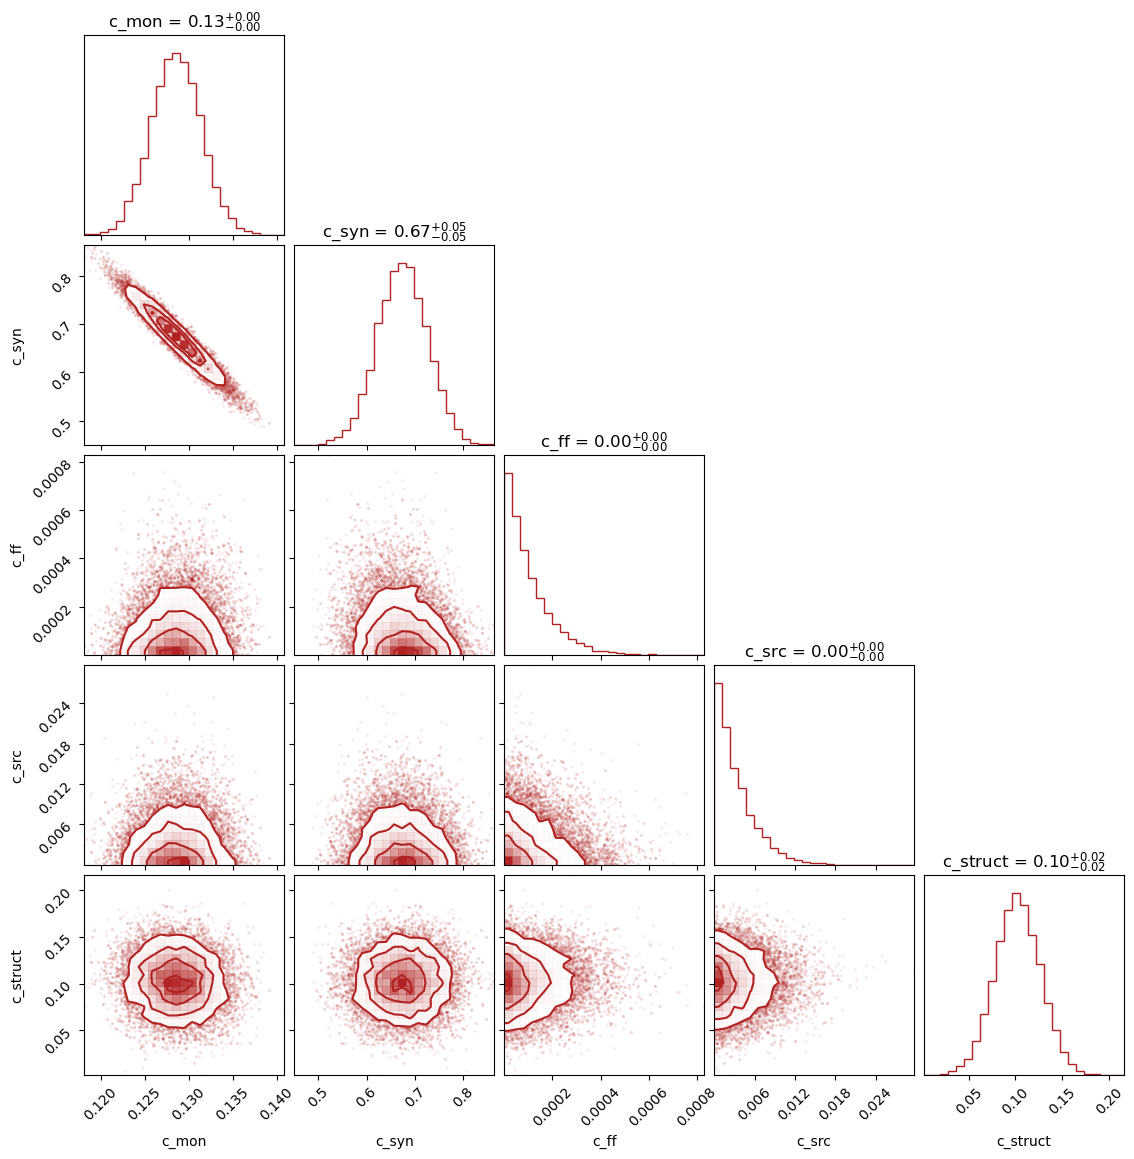

In [404]:
import corner
fig = corner.corner(samples_equal, 
                    bins=25, 
                    show_titles = True,
                    color = 'firebrick', 
                    labels = labels,
                    hist_kwargs={'density': True})

# Draw Sample, convolve with error

In [405]:
c = np.random.multivariate_normal(mean, cov); c

array([1.26152873e-01, 7.16450814e-01, 1.02152035e-04, 1.95044609e-03,
       1.30231453e-01])

In [406]:
c_mon = c[0]
c_synch = c[1]
c_ff = c[2]
c_src = c[3]
c_struct = c[4]

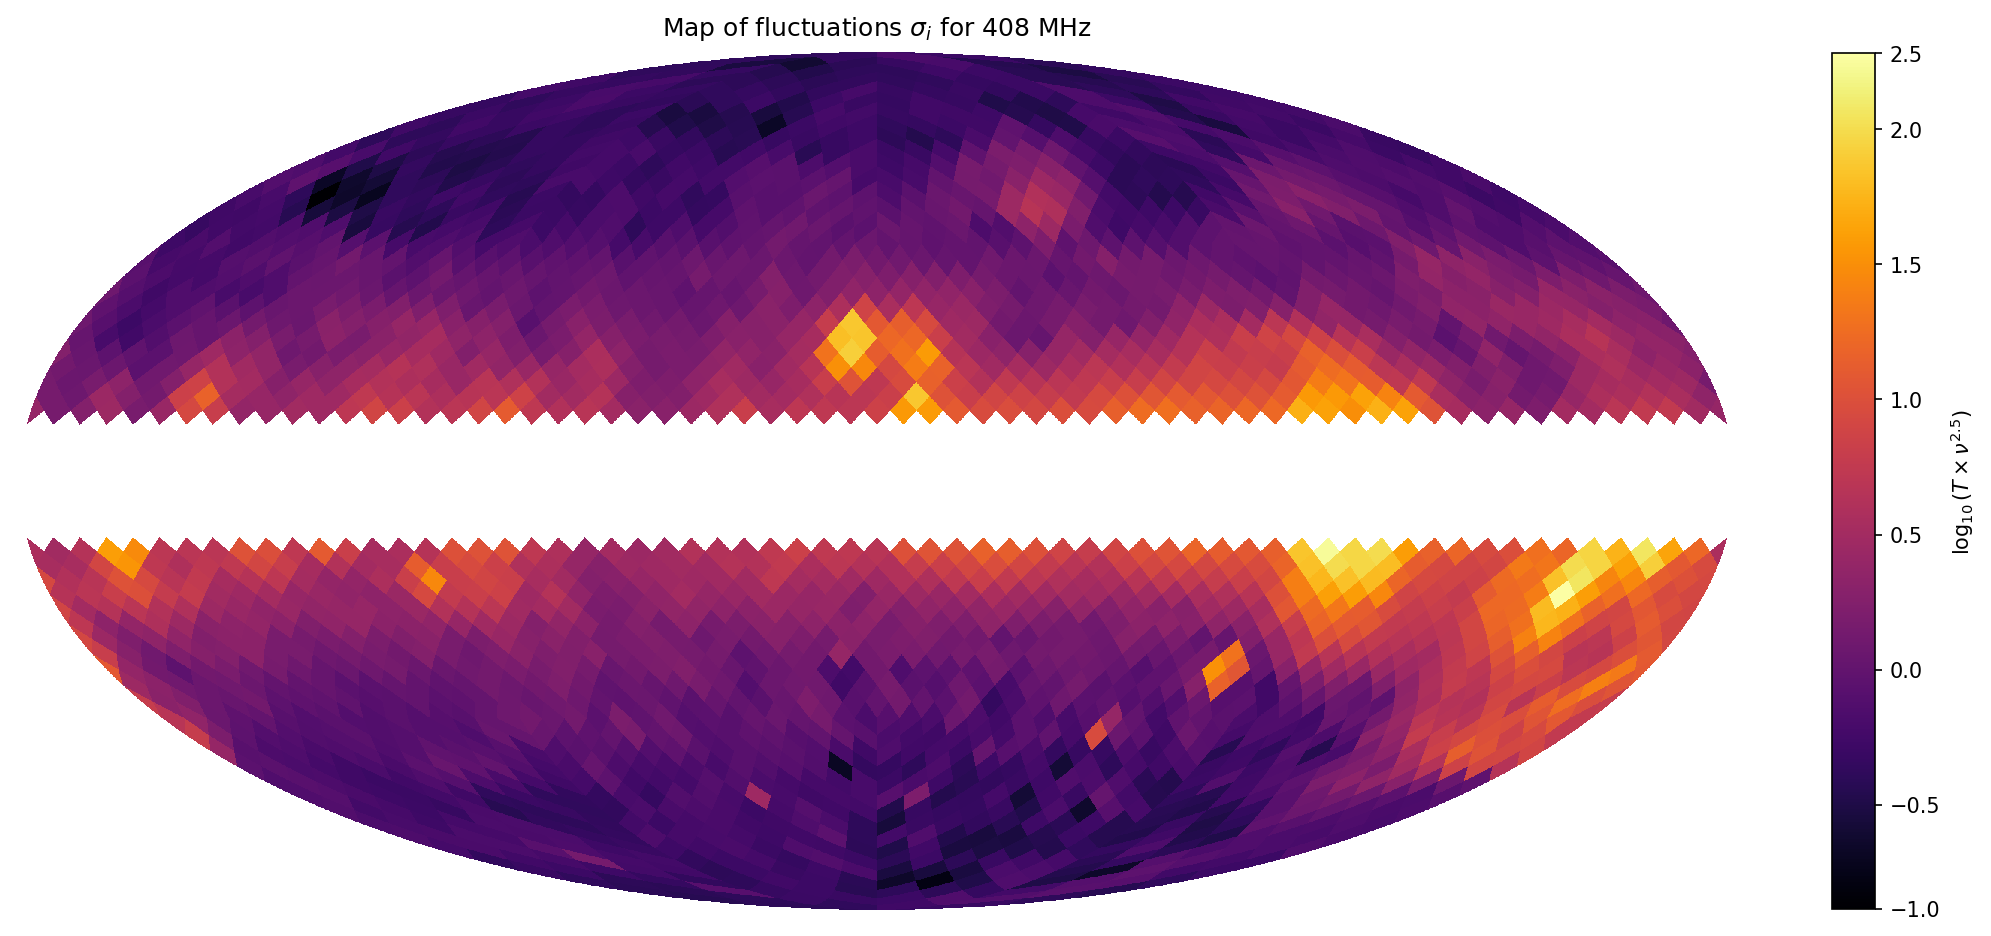

In [407]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10((free_free_dg))
hp.mollview(map, xsize = 4000, nest = False, hold = True, cmap = 'inferno', title=r"Map of fluctuations $\sigma_i$ for 408 MHz", badcolor = 'white', cbar = None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T\times \nu^{2.5})$')

In [408]:
true_map1 = c_mon + c_synch * synch_map_dg  + c_ff * free_free_dg + c_struct * struct_map_dg
true_map2 =  c_src * pt_src_map_dg

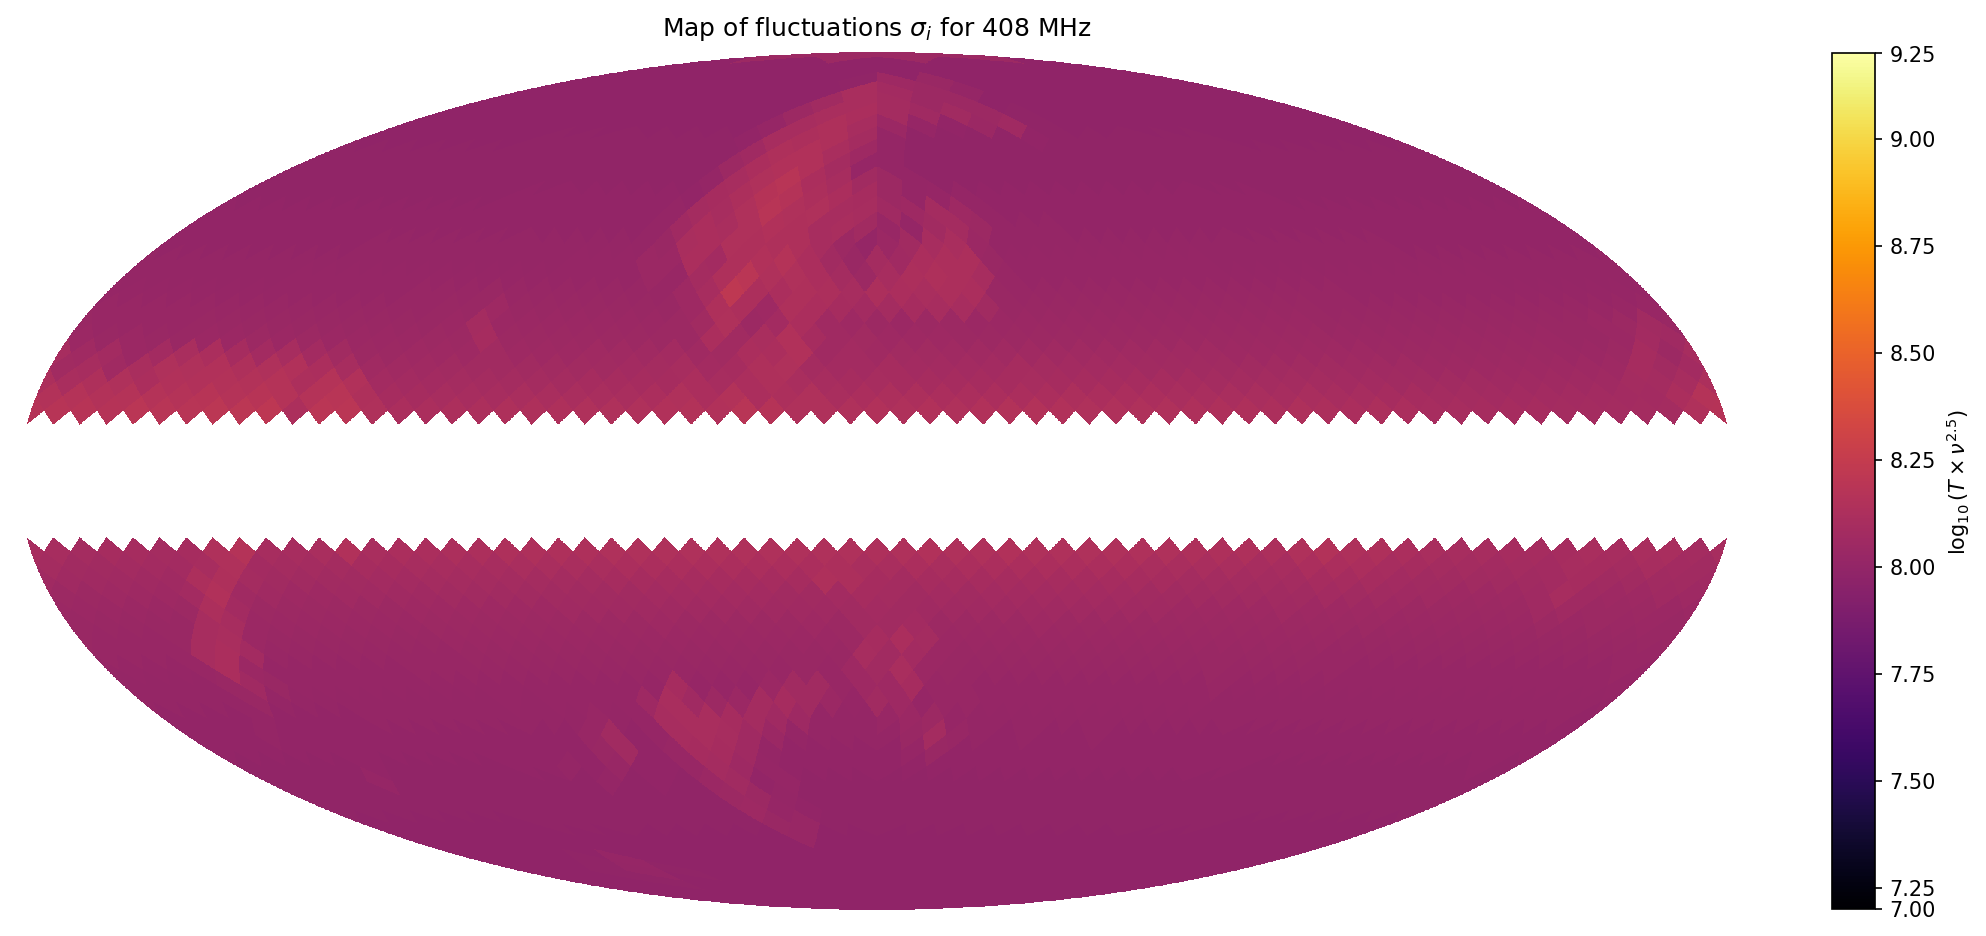

In [409]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(true_map1 * (freq**2.5))
hp.mollview(map, xsize = 4000, nest = False, hold = True, cmap = 'inferno', min = 7.2, max = 9.2, title=r"Map of fluctuations $\sigma_i$ for 408 MHz", badcolor = 'white', cbar = None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T\times \nu^{2.5})$')

In [410]:
meas_map1 = np.asarray([np.random.normal(true_map1[i], np.sqrt(RMS**2 + (CALIB * true_map1[i])**2))
                      for i in range(len(true_map1))])

In [411]:
#meas_map1 = np.random.normal(true_map1, np.sqrt(RMS**2 + (CALIB * true_map1)**2))

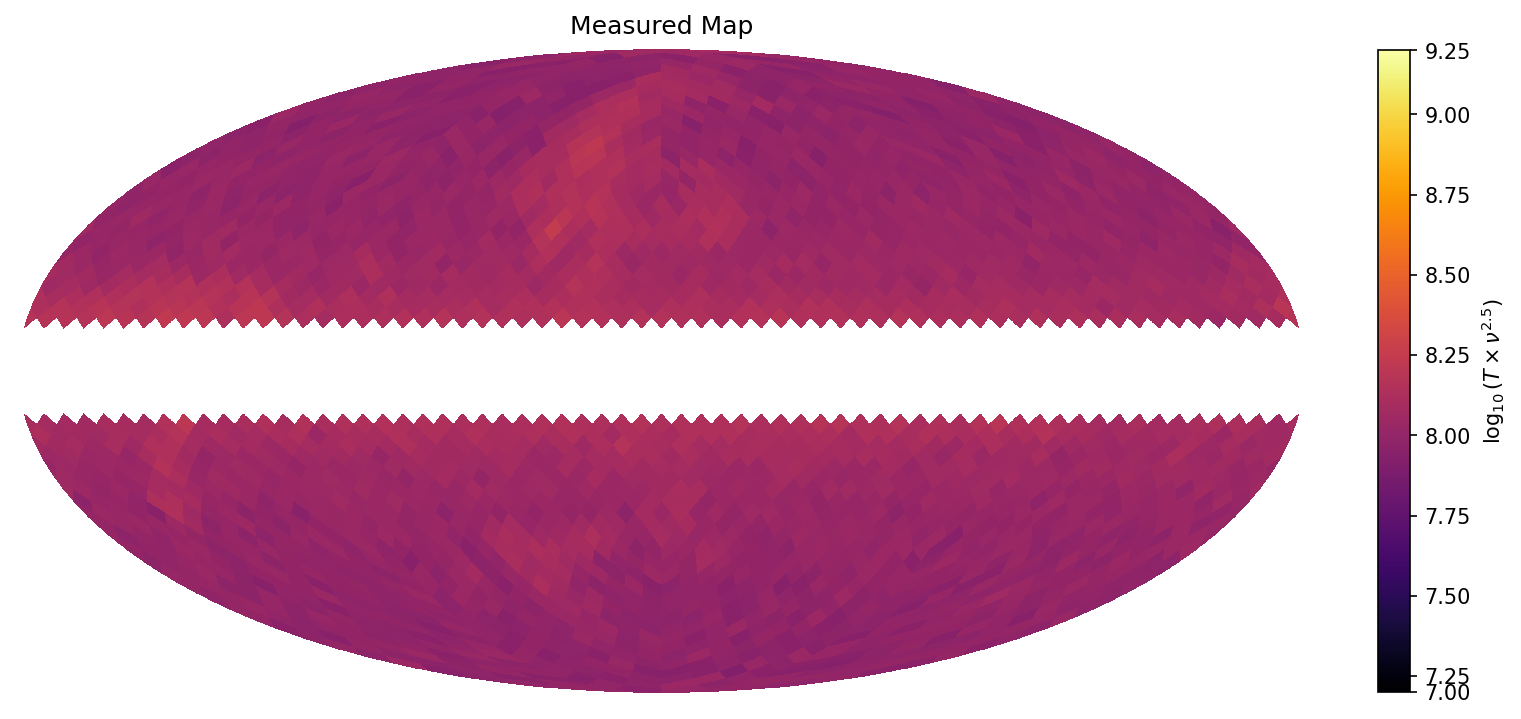

In [412]:
plt.subplots(1,1,figsize=(12,6),dpi = 150)
map = np.log10(meas_map1 * (freq**2.5))
hp.mollview(map, xsize = 4000, nest = False, hold = True, cmap = 'inferno', min = 7.2, max = 9.2, title=r"Measured Map", badcolor = 'white', cbar = None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T\times \nu^{2.5})$')

In [413]:
meas_map2 = np.zeros(len(meas_map1))

In [414]:
meas_map2[true_map2 > 0] = np.random.normal(true_map2[true_map2 > 0], np.sqrt((CALIB * true_map2[true_map2 > 0])**2))

In [415]:
meas_map2 = np.random.normal(true_map2, np.sqrt((CALIB * true_map2)**2))

In [416]:
meas_map2

array([0., 0., 0., ..., 0., 0., 0.])

/tmp/ipykernel_1374908/3351385760.py:2: RuntimeWarning: divide by zero encountered in log10
  map = np.log10(meas_map2 * (freq**2.5))


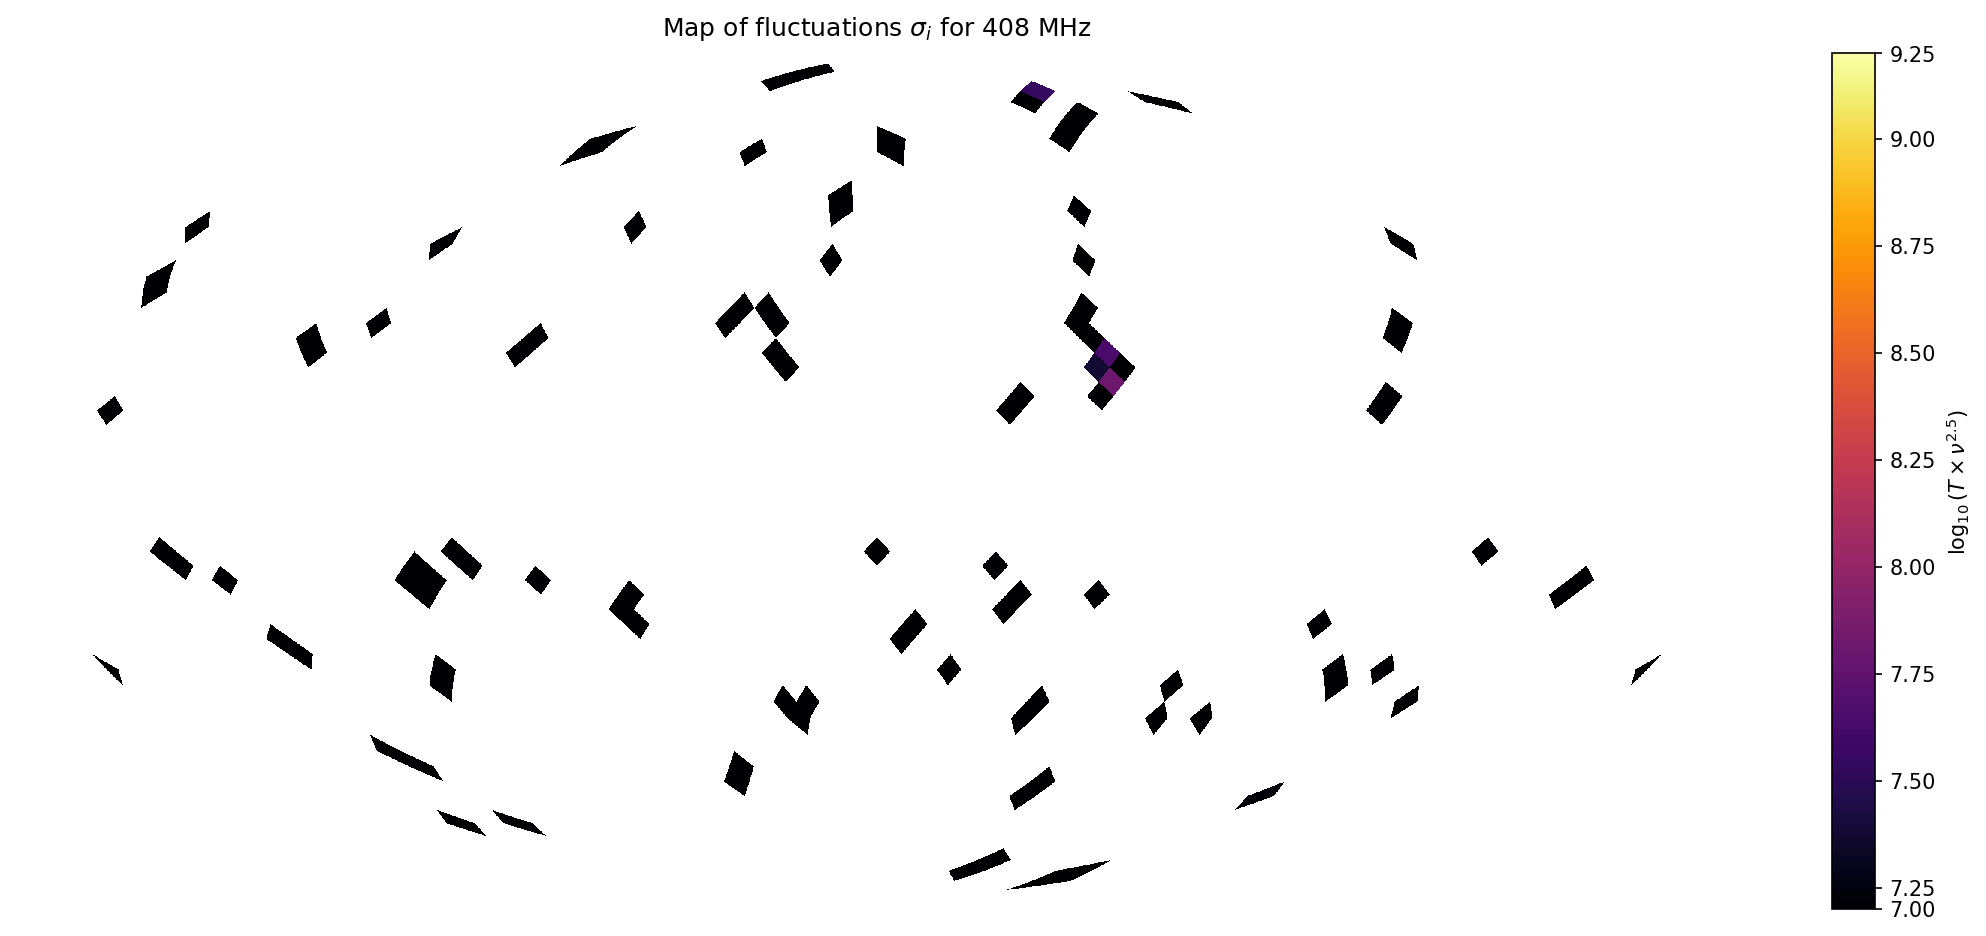

In [417]:
plt.subplots(1,1,figsize=(16,8),dpi = 150)
map = np.log10(meas_map2 * (freq**2.5))
hp.mollview(map, xsize = 4000, nest = False, hold = True, cmap = 'inferno', min = 7.2, max = 9.2, title=r"Map of fluctuations $\sigma_i$ for 408 MHz", badcolor = 'white', cbar = None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T\times \nu^{2.5})$')

In [418]:
meas_map1[np.isnan(meas_map1)] = hp.UNSEEN

In [419]:
smoothed = hp.sphtfunc.smoothing(meas_map1, fwhm = 4 * degree)
smoothed[smoothed < 0] = hp.UNSEEN

In [420]:
meas_map = smoothed + meas_map2
meas_map[np.isnan(data_map_dg)] = np.nan

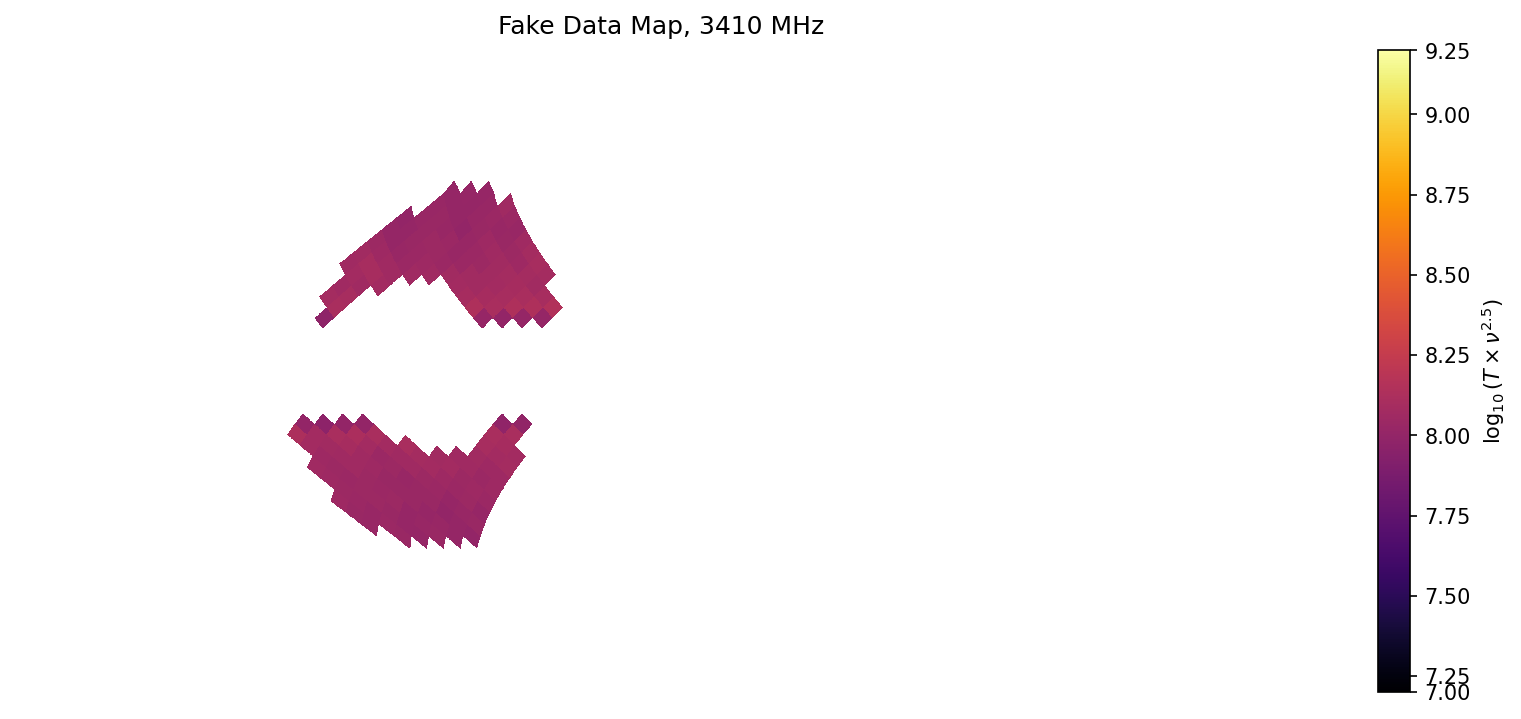

In [421]:
plt.subplots(1,1,figsize=(12,6),dpi = 150)
map = np.log10(meas_map * (freq**2.5))
hp.mollview(map, xsize = 4000, nest = False, hold = True, cmap = 'inferno', min = 7.2, max = 9.2, title=r"Fake Data Map, " + str(freq) + ' MHz', badcolor = 'white', cbar = None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T\times \nu^{2.5})$')

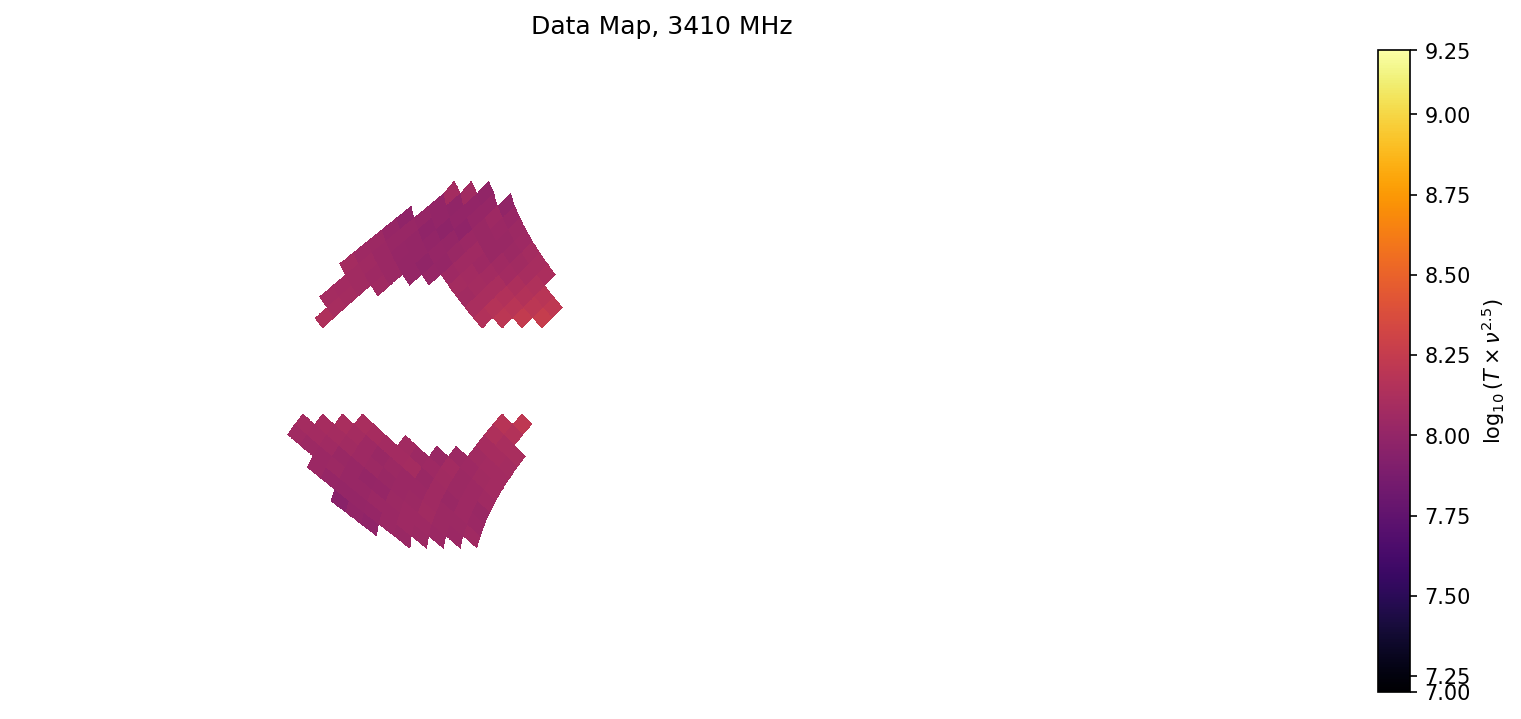

In [422]:
plt.subplots(1,1,figsize=(12,6),dpi = 150)
map = np.log10(data_map_dg * (freq**2.5))
hp.mollview(map, xsize = 4000, nest = False, hold = True, cmap = 'inferno', min = 7.2, max = 9.2, title=r"Data Map, "+ str(freq) + ' MHz', badcolor = 'white', cbar = None)
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label(r'$\log_{10}(T\times \nu^{2.5})$')

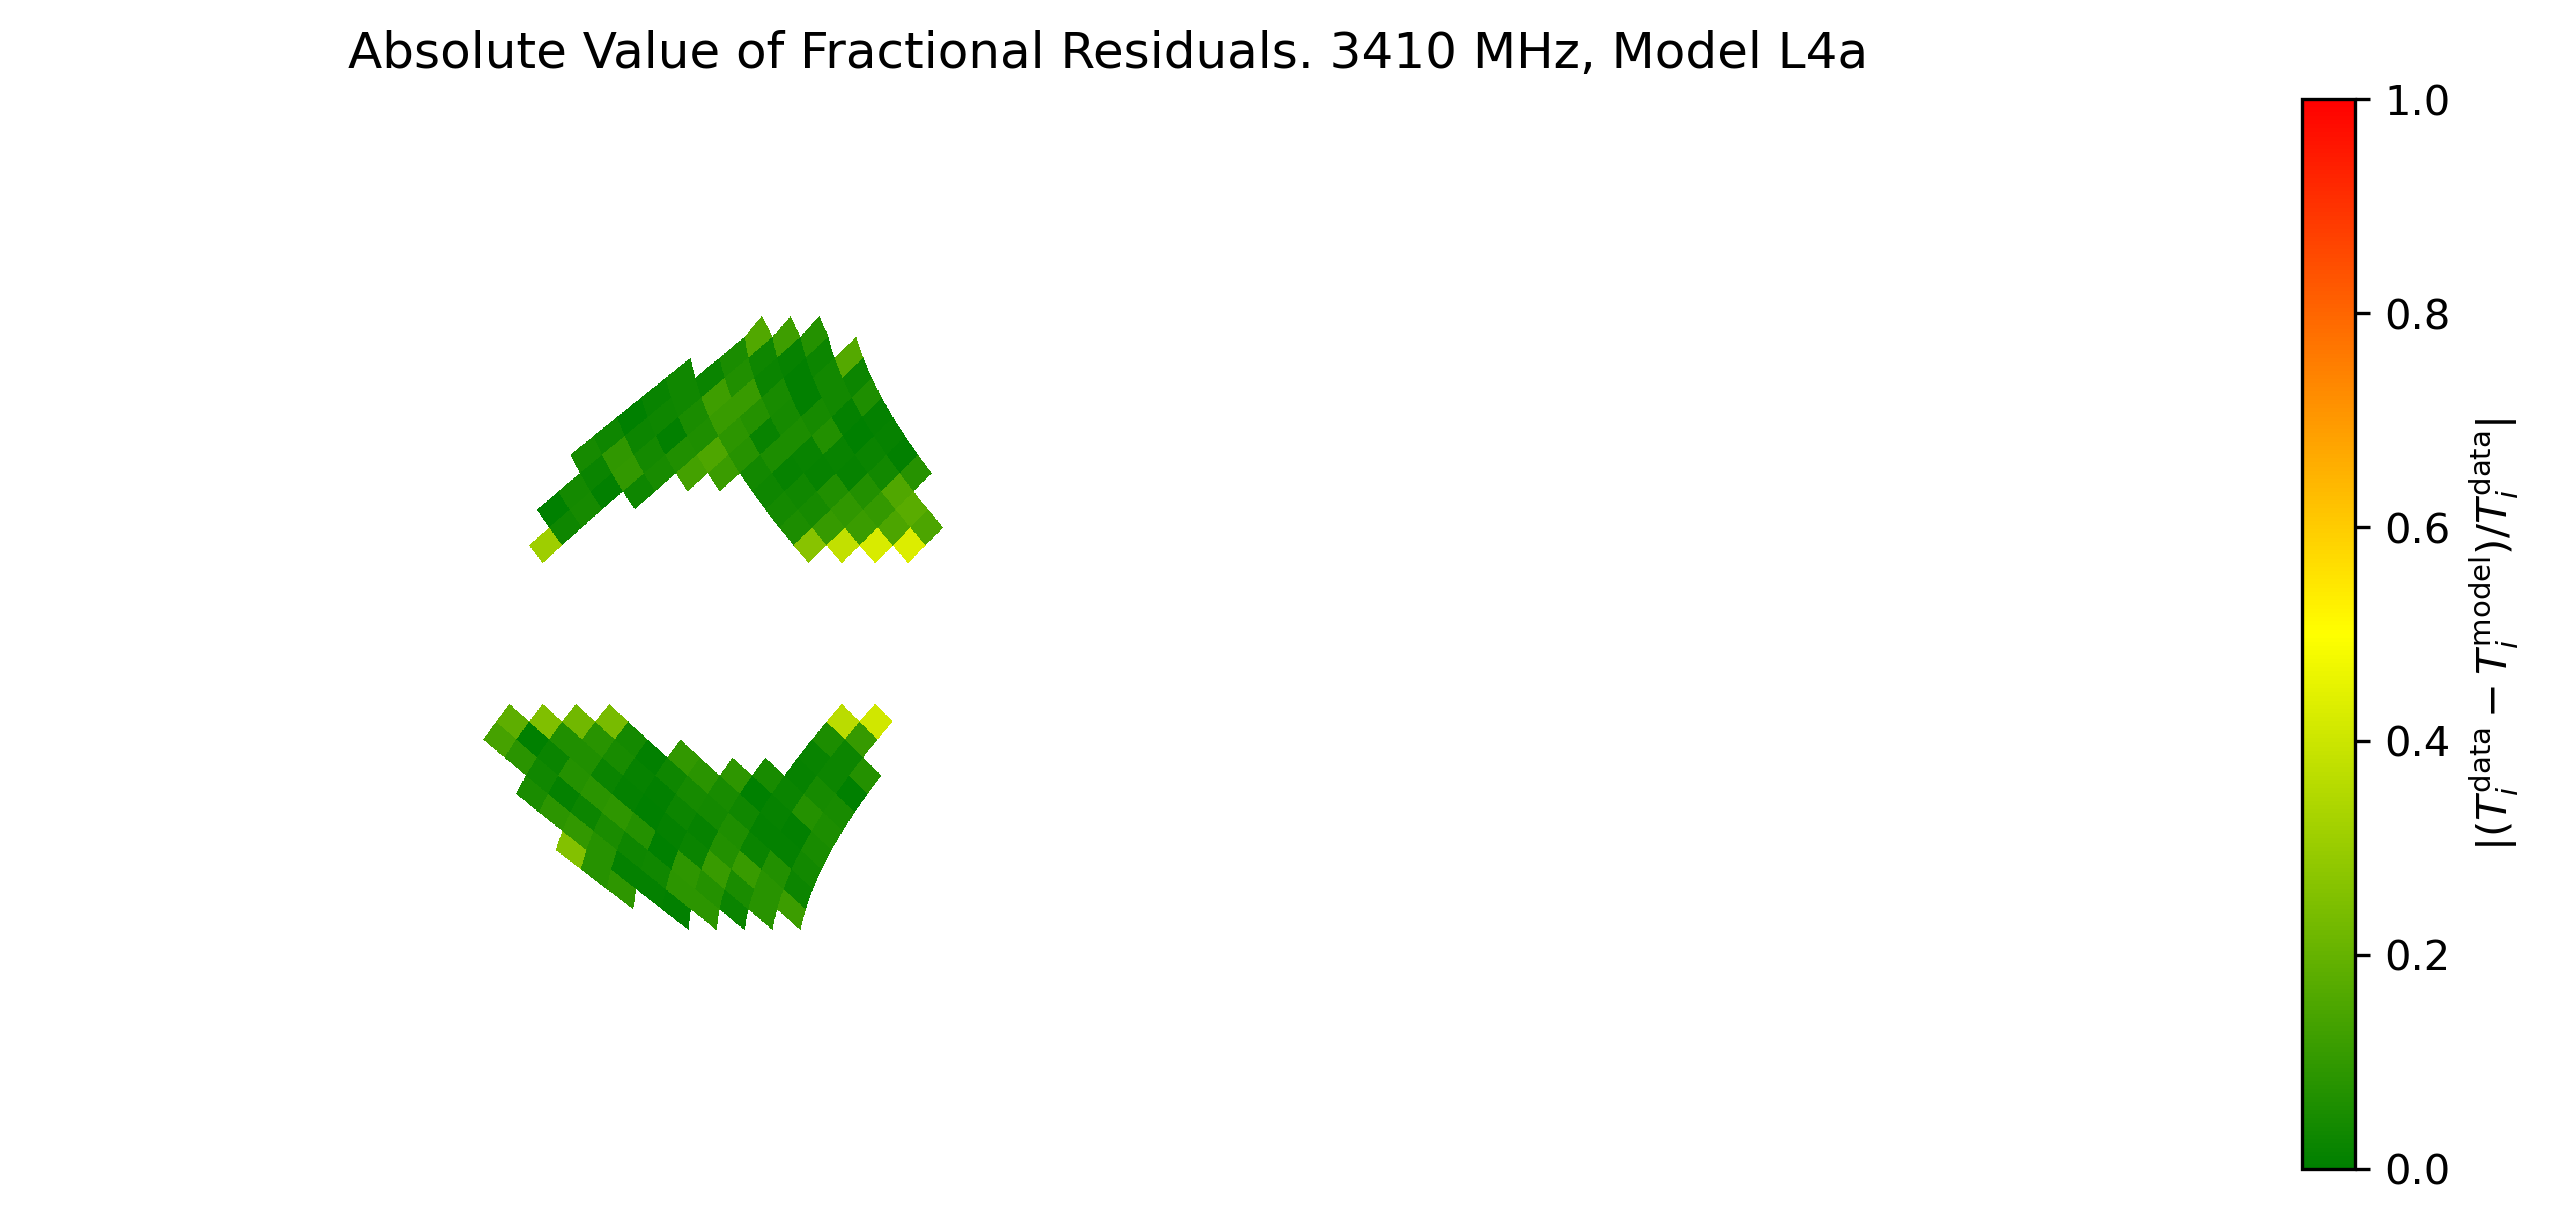

In [423]:
resids = np.abs((data_map_dg - meas_map)/data_map_dg)
my_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
plt.subplots(1,1,figsize=(10,5),dpi = 300)
map = resids
hp.mollview(map, xsize = 4000, nest = False, hold = True, min = 0, max = 1, cbar = False, cmap = my_cmap, title=r"Absolute Value of Fractional Residuals. " + str(freq) +" MHz, Model L4a", badcolor = 'white')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label('$|(T_i^{\mathrm{data}}-T_i^{\mathrm{model}})/T_i^{\mathrm{data}}|$')

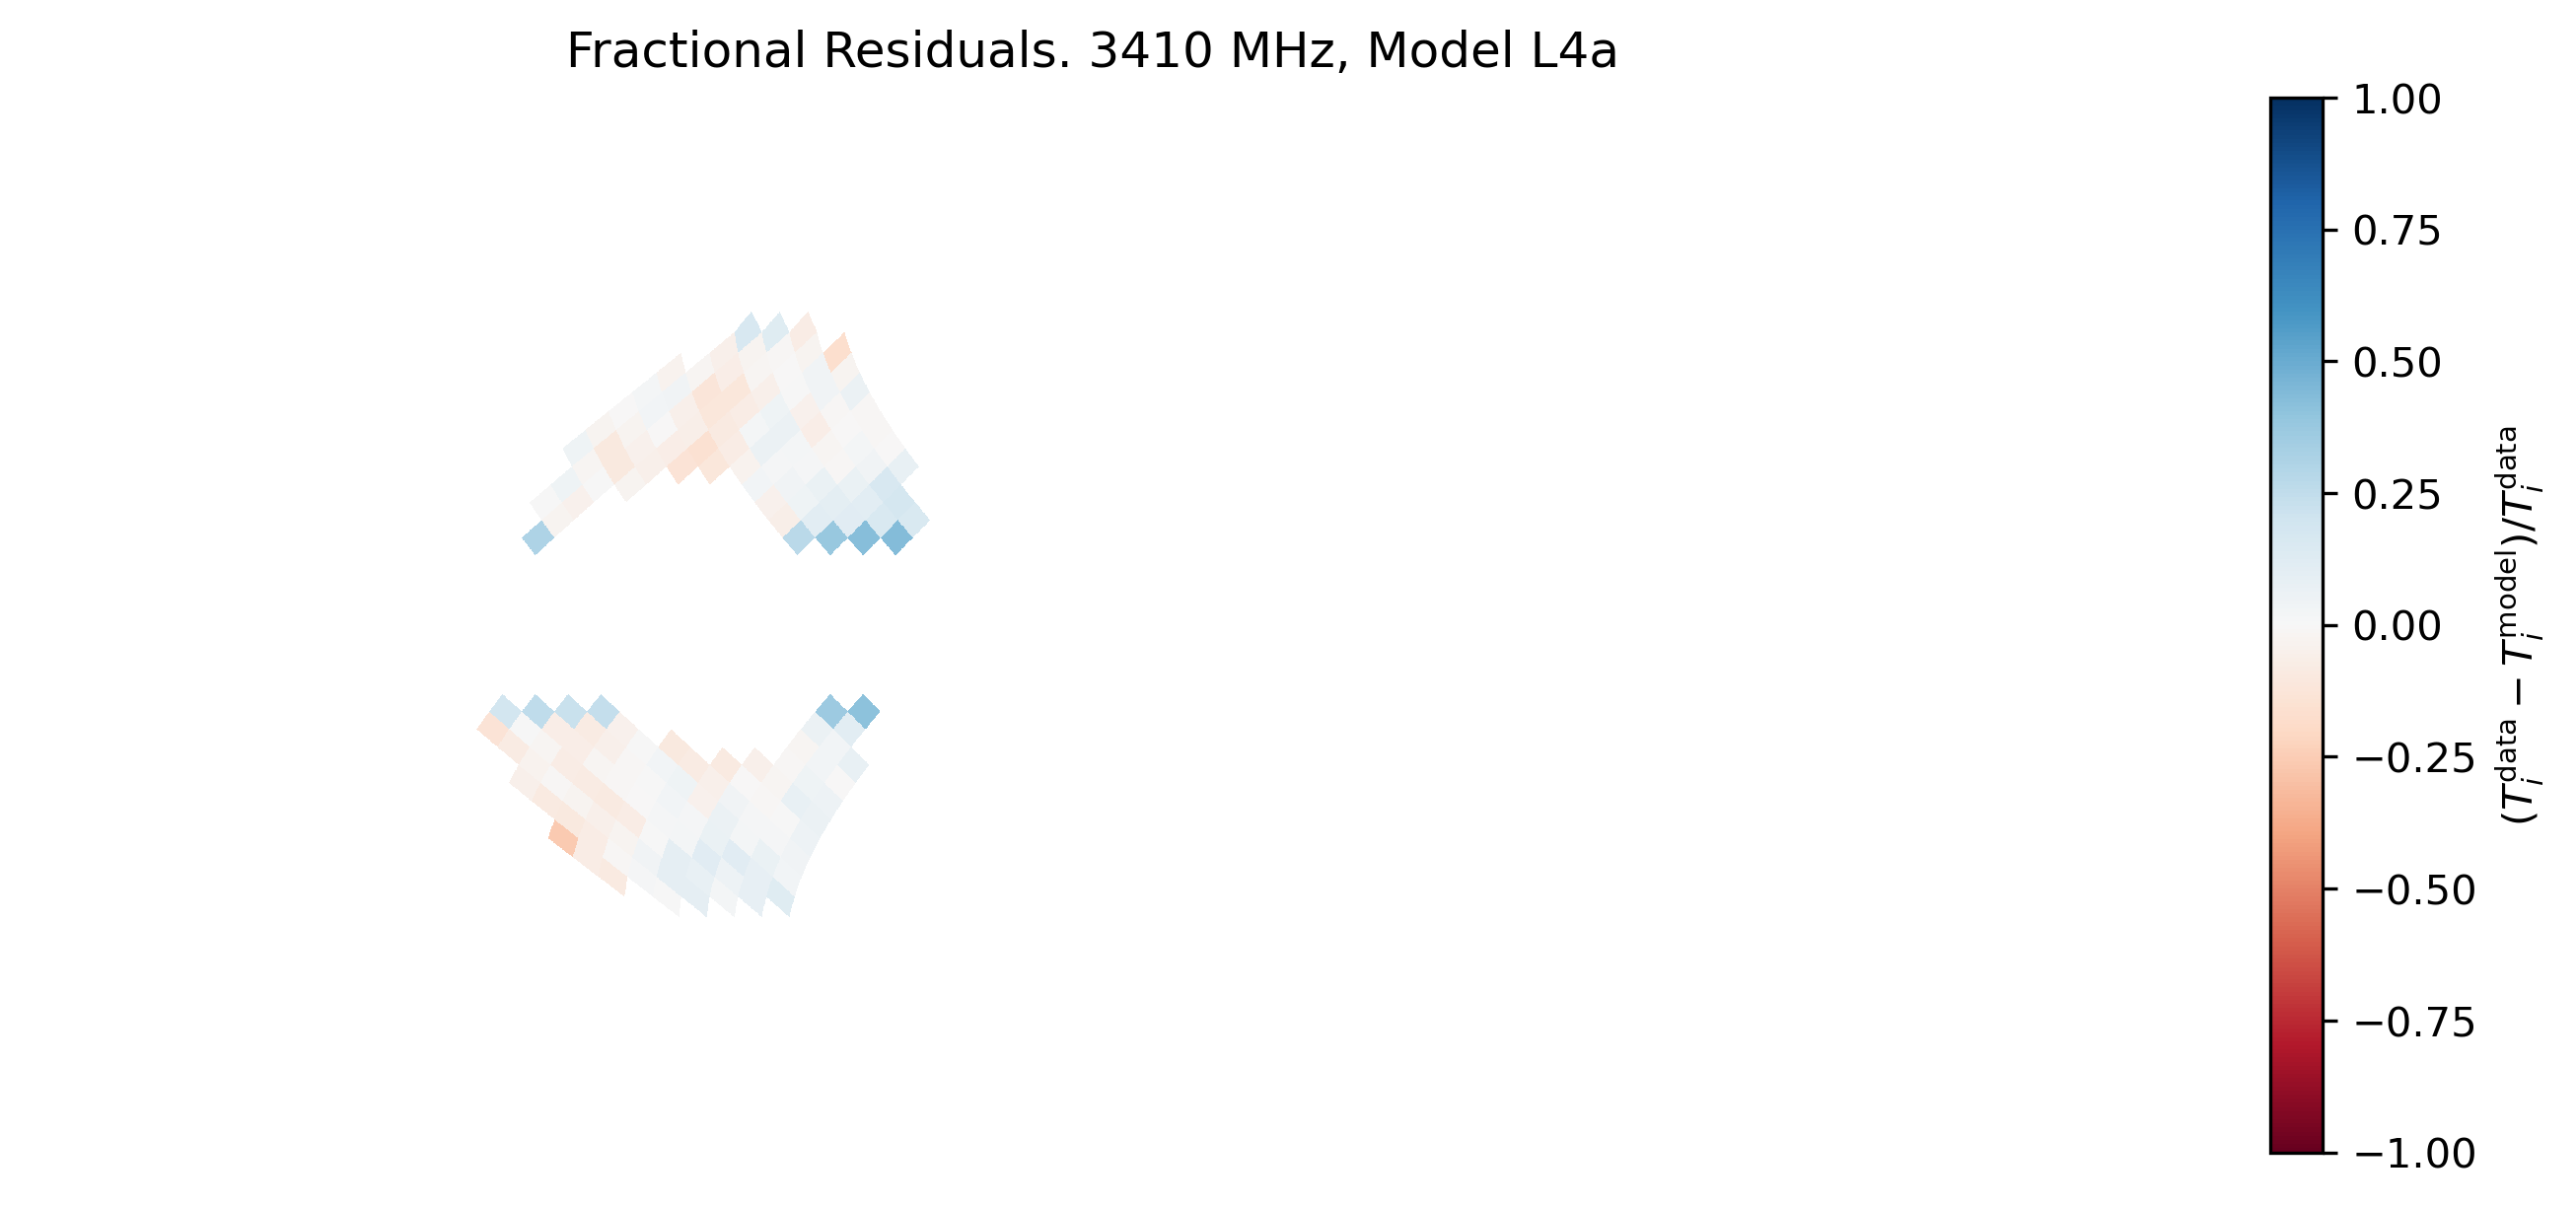

In [424]:
resids = (data_map_dg - meas_map)/data_map_dg
#my_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
plt.subplots(1,1,figsize=(10,5),dpi = 300)
map = resids
hp.mollview(map, xsize = 4000, nest = False, hold = True, min = -1, max = 1, cbar = False, cmap = 'RdBu', title=r"Fractional Residuals. " + str(freq) +" MHz, Model L4a", badcolor = 'white')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.023);
cbar.set_label('$(T_i^{\mathrm{data}}-T_i^{\mathrm{model}})/T_i^{\mathrm{data}}$')